需要解决一个复杂的问题，例如检测高分辨率图像中的数百种物体，可能需要训练更深的ANN，也许有10层或更多层，每层包含数百个神经元，有成千上万个连接。训练深度神经网络不简单。

以下是可能会遇到的一些问题：
- 在训练过程中反向流过DNN时，可能会遇到梯度变得越来越小或越来越大的问题。这两个问题都使较低的层很难训练。
- 对于如此大的网络，可能没有足够的训练数据，或者做标签的成本太高。
- 训练速度可能会非常缓慢。
- 具有数百万个参数的模型会有很高的风险过拟合训练集，尤其是在没有足够的训练实例或噪声太大的情况下。

将研究这些问题，并介绍解决这些问题的技术。首先探索梯度消失和梯度爆炸问题及它们的一些受欢迎的解决方法。接下来，将研究迁移学习和无监督预训练，即使在标签数据很少的情况下，它们也可以帮助你完成复杂的任务。然后，将讨论可以极大加速训练大型模型的各种优化器。最后，我们将介绍一些流行的针对大型神经网络的正则化技术。使用这些工具，就能够训练非常深的网络。

## 梯度消失和梯度爆炸问题

反向传播算法的第二阶段从输出层到输入层，沿途传播误差梯度。一旦算法计算出代价函数相对于网络中每个参数的梯度，就可以通过梯度下降步骤使用这些梯度来更新每个参数。

随着算法向下传播到较低层，梯度通常会越来越小。因此，梯度下降更新使较低层的连接权重保持不变，训练不能收敛到一个最优解。这称为梯度消失问题。在某些情况下，可能会出现相反的情况：梯度可能会越来越大，各层需要更新很大的权重直到算法发散为止。这是梯度爆炸问题，更笼统地说，深度神经网络受梯度不稳定的影响，不同的层可能以不同的速度学习。

查看sigmoid激活函数，可以看到，当输入变大（负数或正数）时，该函数会以0或1饱和，并且导数非常接近0（即曲线在两个极端处都很平坦）。因此，当反向传播开始时，它几乎没有梯度可以通过网络传播回去，并且随着反向传播通过顶层向下传播，存在的少量梯度会不断被稀释，因此对于较低层来说，实际上什么也没有留下

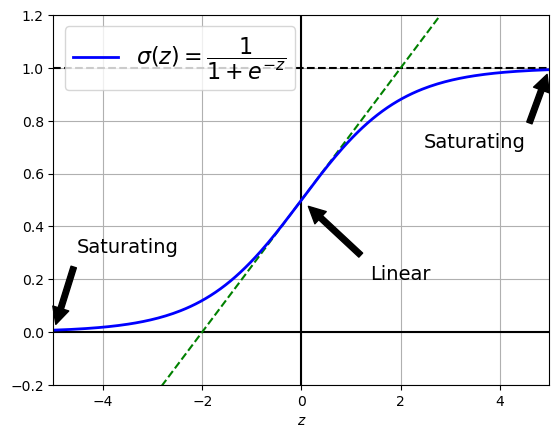

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

### Glorot初始化和He初始化

Glorot和Bengio在他们的论文中提出了一种能显著缓解不稳定梯度问题的方法。他们指出，需要让信号在两个方向上正确流动：在进行预测时，信号正向流动；在反向传播梯度时，信号反向流动。我们既不希望信号消失，也不希望它“爆炸”并“饱和”。

为了使信号正确流动，作者认为，需要让每层输出的方差等于其输入的方差，并且在反方向时需要让梯度流过某层之前和之后具有相同的方差。

除非该层具有相等数量的输入和输出（这些数字称为该层的扇入和扇出），否则实际上不可能同时保证两者，但是Glorot和Bengio提出了一个很好的折中方案，该方案已在实践中证明能够很好地发挥作用：必须按照公式随机初始化每层的连接权重，这种初始化策略称为Xavier初始化或者Glorot初始化，以论文第一作者的名字命名。

随机初始化权重公式：使用sigmoid激活函数时，均值为0，方差为1/fan_avg的正态分布 或 -r和+r之间的均匀分布，其中r=sqrt(3/fan_avg), 其中fan_avg = (fan_in + fan_out) / 2

如果在公式中用`fan_in`替换`fan_avg`，则会得到Yann LeCun在20世纪90年代提出的初始化策略。他称之为**LeCun初始化**。

当`fan_in = fan_out`时，LeCun初始化等效于Glorot初始化。

研究人员花了十多年的时间才意识到这一技巧的重要性: 使用Glorot初始化可以大大加快训练速度，这是导致深度学习成功的实践之一。


一些论文为不同的激活函数提供了类似的策略。这些策略的差异仅在于方差的大小以及它们使用的是`fan_avg`还是`fan_in`，如表中所示（对于均匀分布，只需使用$-\sqrt{3\sigma^2}$到$\sqrt{3\sigma^2}$的范围）。为ReLU激活函数及其变体提出的初始化策略称为**He初始化**或**Kaiming初始化**，以论文第一作者[何恺明] 名字命名。对于SELU，使用Yann LeCun的初始化方法，最好使用正态分布。

**表：每种激活函数的初始化参数**

| 初始化方法      | 激活函数                          | $\sigma^2$ (方差)             |
|-----------------|-----------------------------------|-----------------------------|
| Glorot 初始化   | None、tanh、sigmoid、softmax      | $1/\text{fan}_{\text{avg}}$ |
| He 初始化       | ReLU、Leaky ReLU、ELU、GELU、Swish、Mish | $2/\text{fan}_{\text{in}}$  |
| LeCun 初始化    | SELU                              | $1/\text{fan}_{\text{in}}$  |

默认情况下，Keras使用具有均匀分布的Glorot初始化。创建层时，可以通过设置`kernel_initializer="he_uniform"`或`kernel_initializer="he_normal"`来将其更改为He初始化：

In [2]:
import tensorflow as tf
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

或者，可以使用VarianceScaling初始化器获得表中列出的任何初始化以及更多。例如，如果想用均匀分布并且基于fan_avg（而不是fan_in）进行He初始化，则可以使用下面的代码：

In [3]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer=he_avg_init)

### 更好的激活函数

Glorot和Bengio在2010年的论文中提出的一项见解是，梯度不稳定的问题部分原因是激活函数选择不当。在此之前，大多数人都认为使用类似sigmoid的激活函数必定是一个好选择。

但是事实证明，其他激活函数在深度神经网络中的表现要更好，尤其是ReLU激活函数，主要是因为它不会在正值输入下饱和，而且它的计算速度非常快。

不幸的是，ReLU激活函数并不完美。它有一个被称为“濒死的ReLUs”的问题：在训练过程中，某些神经元实际上“死亡”了，这意味着它们停止输出除0以外的任何值。在某些情况下，可能会发现网络中一半的神经元都“死亡”了，特别是使用较大的学习率时。当神经元的权重被调整为ReLU函数的输入（即神经元输入的加权和加上它的偏置项）对于训练集中的所有实例都为负时，神经元就会“死亡”。当发生这种情况时，它只会继续输出0，梯度下降不会再影响它，因为ReLU函数的输入为负时其梯度为零。

要解决此问题，你可能需要使用ReLU函数的变体，例如leaky ReLU。

(注意：除非神经元在第一个隐藏层，否则“死亡”的神经元可能会复活：梯度下降会调整各层中的神经元，使得“死亡”神经元输入的加权和再次为正）

#### leaky Relu

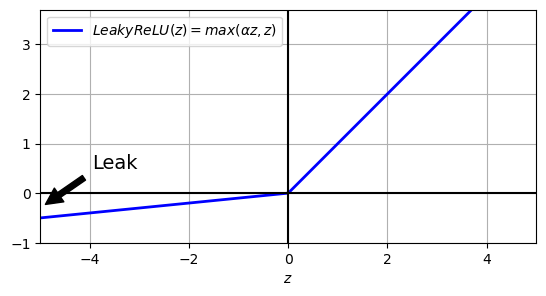

In [6]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

该函数定义为 $\text{leakyReLU}_\alpha(z) = \max(\alpha z, z)$。超参数 $\alpha$ 定义函数“泄漏”的程度：它是 $z < 0$ 时函数的斜率。$z < 0$ 时的斜率确保 leaky ReLU 永不“死亡”，它们可能会陷入长时间的“昏迷”，但是有机会“醒来”。

2015年的一篇论文比较了ReLU激活函数的几种变体，其结论之一是leaky变体要好于严格的ReLU激活函数。实际上，设置 $\alpha = 0.2$（大泄漏）似乎比 $\alpha = 0.01$（小泄漏）能产生更好的性能。

该论文还对**随机性leaky ReLU (RReLU)** 进行了评估，在训练过程中在给定范围内随机选择 $\alpha$，在测试过程中将其固定为均值。RReLU的表现也相当不错，似乎可以充当正则化函数，降低了过度拟合训练集的风险。

该论文评估了**参数化leaky ReLU (PReLU)**，其中 $\alpha$ 可以在训练期间学习（不是超参数），它像其他任何参数一样，可以通过反向传播进行修改。据报道，PReLU在大型图像数据集上的性能明显优于ReLU，但是在较小的数据集上，它存在过度拟合训练集的风险。

In [ ]:
# Keras在tf.keras.layers包中包含LeakyReLU和PReLU类
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3


dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")   # Relu变体使用He初始化

In [7]:
# 将LeakyReLU单独用作模型中的层，和之前写activation = leak_relu,对比，对训练和预测没有影响
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # 激活函数作为一个独立的层
    # [...]  # more layers
])

#### ELU和SELU

ReLU，leaky ReLU都有不是光滑函数的缺点：它们的导数会突然变化，这种不连续性会使梯度下降在最优值附近反弹，并减慢收敛速度。所以关注ReLU激活函数的一些平滑变体：从ELU和SELU开始



2015年提出了一种新的激活函数，称为**指数线性单元 (ELU)**，在作者的实验中其性能优于所有ReLU变体：训练时间减少，神经网络在测试集上表现更好。公式显示了该激活函数的定义。


$$
\text{ELU}_{\alpha}(z) =
\begin{cases}
\alpha(\exp(z)-1), & z < 0 \\
z, & z \geq 0
\end{cases}
$$


ELU激活函数看起来很像ReLU函数，但有几个主要区别：

- **负值输出**：当 \( z < 0 \) 时，它取负值，这使该单元的平均输出接近于0，有助于缓解梯度消失问题。超参数 \( alpha ) 定义为绝对值较大的负数时 ELU 函数逼近的值的相反值。通常将其设置为1，但是你可以像对其他任何超参数一样对其进行调整。

- **非零梯度**：对于 \( z < 0 \)，它具有非零梯度，从而避免了神经元"死亡"的问题。

- **平滑性**：如果 \( alpha ) 等于1，则该函数在所有位置（包括 \( z = 0 \) 左右）都是平滑的，这有助于加速梯度下降，因为它在 \( z = 0 \) 的左右两侧弹跳不大。


在Keras中使用ELU就像设置 `activation="elu"` 一样简单，并且与其他ReLU变体一样，应该使用**He初始化**。


**优点**：
- 训练过程中收敛更快
- 缓解梯度消失问题
- 避免神经元死亡问题

**缺点**：
- 计算速度比ReLU函数及其变体要慢（因为使用了指数函数）
- 在测试时，ELU网络速度将比ReLU网络的慢一点

> 注意：ELU在训练过程中更快的收敛速度通常可以弥补其计算缓慢的缺点。

 不久之后，2017年提出了**可扩展的ELU (Scaled ELU，SELU)** 激活函数：顾名思义，它是ELU激活函数的可扩展实体（约1.05倍ELU，使用α≈1.67）。

作者表明，如果构建一个仅由密集层堆叠组成的神经网络（即MLP），并且所有隐藏层都使用SELU激活函数，则该网络是**自归一化的**：每层的输出倾向于在训练过程中保留均值0和标准差1，从而解决了梯度消失和梯度爆炸的问题。因此，SELU激活函数可能优于MLP（尤其是深度MLP）的其他激活函数。

要在Keras中使用，只需设置 `activation="selu"`。然而，自归一化的发生有几个条件：

- **输入特征标准化**：输入特征必须是标准化的，平均值为0，标准差为1。
- **权重初始化**：每个隐藏层的权重必须使用LeCun初始化（采用正态分布）。在Keras中，这意味着设置 `kernel_initializer="lecun_normal"`。
- **架构限制**：自归一化属性只能通过普通MLP来保证。如果尝试在其他架构中使用SELU，例如在循环神经网络（后期学习的神经网络架构）或具有跳过连接的网络[即跳过层的连接，例如宽深(Wide & Deep)网络]，它可能不会优于ELU。
- **正则化限制**：不能使用正则化技术，例如L1/L2正则化、最大范数、批处理归一化或常规dropout（这些将在后面讨论）。

这些都是重要约束，因此尽管SELU在MLP上有前途，并没有获得很大的吸引力。此外，另外三个激活函数似乎在大多数任务上的表现都非常稳定：GELU、Swish和Mish。

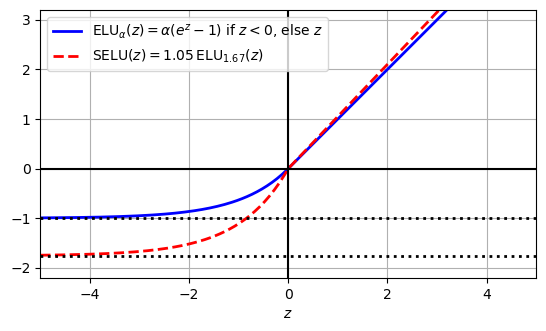

In [10]:
from scipy.special import erfc

# 互补误差函数 erfc(z)：它计算的是从 z 到无穷大的高斯分布曲线下的面积。
# SELU 函数的参数 alpha 和 scale 的推导过程复杂，涉及到确保输出均值为 0、方差为 1 的积分计算。这些积分的形式与高斯分布密切相关，因此自然就会用到 erfc 函数。
# 代码中的 alpha_0_1 和 scale_0_1 的复杂表达式是这些积分计算的结果。
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [1]:
import tensorflow as tf

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [2]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [6]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 26s 12ms/step - loss: 1.0817 - accuracy: 0.5964 - val_loss: 0.9169 - val_accuracy: 0.6936
Epoch 2/5
1719/1719 [==============================] - 20s 11ms/step - loss: 1.0651 - accuracy: 0.6112 - val_loss: 0.9087 - val_accuracy: 0.6630
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7705 - accuracy: 0.7107 - val_loss: 0.6405 - val_accuracy: 0.7644
Epoch 4/5
1719/1719 [==============================] - 49s 29ms/step - loss: 0.6460 - accuracy: 0.7602 - val_loss: 0.5792 - val_accuracy: 0.7878
Epoch 5/5
1719/1719 [==============================] - 49s 29ms/step - loss: 0.5723 - accuracy: 0.7906 - val_loss: 0.5524 - val_accuracy: 0.7930


In [7]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [8]:
# 使用relu学习效果不好，遇到了梯度消失/爆炸的问题， Selu避免了这个问题

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 10ms/step - loss: 2.1904 - accuracy: 0.1671 - val_loss: 2.5639 - val_accuracy: 0.1554
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.5627 - accuracy: 0.3521 - val_loss: 1.3026 - val_accuracy: 0.4226
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.0789 - accuracy: 0.5537 - val_loss: 1.1081 - val_accuracy: 0.5780
Epoch 4/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8924 - accuracy: 0.6428 - val_loss: 0.9461 - val_accuracy: 0.6006
Epoch 5/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8282 - accuracy: 0.6642 - val_loss: 1.5407 - val_accuracy: 0.4474


#### GELU, Swish和Mish

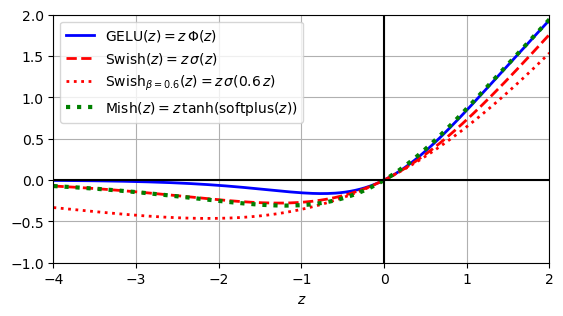

In [25]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")


plt.show()

GELU在2016年引入。同样，可以将其视为ReLU激活函数的平滑实体。其定义在公式中给出，其中$\Phi$是标准高斯累积分布函数(CDF)：$\Phi(z)$对应于从均值为0、方差为1的正态分布中随机采样的值低于z的概率。

**公式：GELU激活函数**

$$
\text{GELU}(z) = z\Phi(z)
$$

如上图所示，GELU类似于ReLU：当其输入$z$为负时，它接近于0；当z为正时，它接近z。然而，尽管我们目前讨论的所有激活函数都是凸函数和单调函数，但GELU激活函数两者都不是：从左到右，它从直线开始，然后向下摆动，到达附近的低点-0.17（接近z < -0.75），最后弹起并最终直奔右上角。

这种相当复杂的形状以及它在每个点都有曲率的事实可以解释为什么它工作得如此好，特别是对于复杂的任务：梯度下降可能会发现它更容易适应复杂的模式。在实践中，它通常优于目前讨论的所有其他激活函数。

然而，它的计算量更大一些，而且它的性能提升并不总是足以证明出额外代价的合理性。也就是说，可以证明它近似等于$z\sigma(1.702z)$，其中$\sigma$是sigmoid函数：使用这种近似值也很有效，而且它的优点是计算速度快得多。

GELU论文还引入了sigmoid线性单元(SiLU)激活函数，它等于 $z\sigma(z)$，但在作者的测试中已被GELU超越了。有趣的是，其他人在2017年发表的论文中中通过自动搜索好的激活函数重新发现了SiLU函数。作者将其命名为**Swish**，并且这个名字流行了起来。

在他们的论文中，Swish优于其他所有函数，包括GELU。Ramachandran等人后来通过添加额外的超参数$\beta$来缩放sigmoid函数的输入，从而泛化了Swish。广义Swish函数为 $\text{Swish}_\beta(z) = z\sigma(\beta z)$，因此GELU近似等于使用$\beta = 1.702$的广义Swish函数。

可以像调整任何其他超参数一样调整$\beta$。你也可以使$\beta$可以通过梯度下降对其进行优化：与PReLU非常相似，这可以使模型更强大，但它也存在过度拟合数据的风险。

另一个非常相似的激活函数是**Mish**，它是在2019年发表的论文中介绍的。它被定义为 $\text{Mish}(z) = z\tanh(\text{softplus}(z))$，其中 $\text{softplus}(z) = \log(1 + \exp(z))$。

就像GELU和Swish一样，它是ReLU的平滑、非凸和非单调变体。同样，作者进行了许多实验，发现Mish通常优于其他激活函数——即使是Swish和GELU，有微小的差距。

上图示了GELU、Swish（默认$\beta = 1$和$\beta = 0.6$），以及Mish激活函数。当$z$为负时，Mish与Swish几乎完美重叠，而当$z$为正时，与GELU几乎完美重叠。

应该为深度神经网络的隐藏层使用哪种激活函数呢？

- ReLU仍然是简单任务的良好默认选择：它通常与更复杂的激活函数一样好，而且计算速度非常快，许多库和硬件加速器提供特定于ReLU的优化方式。
- 但是，对于复杂的任务，Swish可能是更好的默认设置，
- 对于非常复杂的任务，甚至可以尝试使用具有可学习的β参数的参数化Swish。Mish可能会带来更好的结果，但它需要更多的计算量。
- 如果你非常关心运行时延迟，那可能更喜欢leaky ReLU，或者适合复杂任务的参数化leaky ReLU。
- 对于深度MLP，请尝试使用SELU，但请确保遵守前面列出的约束。
- 如果你有空闲时间和计算能力，也可以使用交叉验证来评估其他激活函数。

Keras开箱即用地支持GELU和Swish；只需使用activation="gelu"或activation="swish"。但是，它还不支持Mish或广义的Swish激活函数 （后续会学自定义激活函数和层）

In [9]:
# 随堂练习：尝试使用gelu/swish / 参数化的leak relu(tf.keras.layers.PReLU)

# leaky_relu(z) = max(az, z)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.PReLU(),  # 激活函数作为一个独立的层
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),
    tf.keras.layers.PReLU(),  # 激活函数作为一个独立的层
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_202 (Dense)           (None, 50)                39250     
                                                                 
 p_re_lu (PReLU)             (None, 50)                50        
                                                                 
 dense_203 (Dense)           (None, 50)                2550      
                                                                 
 p_re_lu_1 (PReLU)           (None, 50)                50        
                                                                 
 dense_204 (Dense)           (None, 10)                510       
                                                                 
Total params: 42410 (165.66 KB)
Trainable params: 4241

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0246 - accuracy: 0.6674 - val_loss: 0.6798 - val_accuracy: 0.7696
Epoch 2/5
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6242 - accuracy: 0.7839 - val_loss: 0.5610 - val_accuracy: 0.8014
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5425 - accuracy: 0.8087 - val_loss: 0.5109 - val_accuracy: 0.8158
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4998 - accuracy: 0.8231 - val_loss: 0.4824 - val_accuracy: 0.8268
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4723 - accuracy: 0.8327 - val_loss: 0.4619 - val_accuracy: 0.8334


### 批量归一化

尽管将 He 初始化与 ReLU（或其任何变体）一起使用可以显著降低在训练开始时出现梯度消失/爆炸问题的风险，但这并不能保证它们在训练期间不会再出现。

在2015年提出了一种称为**批量归一化（Batch Normalization，BN）** 的技术来解决这些问题。该技术包括在模型中每个隐藏层的激活函数之前或之后添加一个操作。该操作对每个输入进行零中心化并归一化，然后在每层使用两个新的参数向量缩放并偏移其结果：一个用于缩放，另一个用于偏移。换句话说，该操作可以使模型学习各层输入的最佳缩放和均值。在许多情况下，如果将 BN 层添加为神经网络的第一层，则无须归一化训练集（也就是说，不需要使用 `StandardScaler` 或 `Normalization`），BN 层会为你完成此操作（因为它一次只能查看一个批次，它还可以重新缩放和偏移每个输入特征）。

为了使输入零中心化并归一化，该算法需要估计每个输入的均值和标准差。我们通过评估当前小批次上的输入的均值和标准差（因此称为“批量归一化”）来实现。下面公式逐步总结了整个操作。

**公式：批量归一化算法**

1. $$\mu_B = \frac{1}{m_B} \sum_{i=1}^{m_B} \mathbf{x}^{(i)}$$
2. $$\sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} (\mathbf{x}^{(i)} - \mu_B)^2$$
3. $$\hat{\mathbf{x}}^{(i)} = \frac{\mathbf{x}^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
4. $$\mathbf{z}^{(i)} = \boldsymbol{\gamma} \otimes \hat{\mathbf{x}}^{(i)} + \boldsymbol{\beta}$$

在此算法中：

- $\mu_B$ 是输入均值的向量，在整个小批次 $B$ 上评估（每个输入包含一个均值）。
- $m_B$ 是小批次中的实例数量。
- $\sigma_B$ 是输入标准差的向量，也在整个小批次上评估（每个输入包含一个标准差）。
- $\epsilon$ 是一个平滑项，用于避免除以零（通常取一个很小的值，例如 $10^{-5}$）。
- $\boldsymbol{\gamma}$ 是层的缩放参数向量（每个输入包含一个缩放参数）。
- $\boldsymbol{\beta}$ 是层的偏移参数向量（每个输入包含一个缩放参数    ）。
- $\otimes$ 表示逐元素乘法（每个输入乘以其相应的输出缩放参数）。
- $\mathbf{z}^{(i)}$ 是 BN 操作的输出，将传递给下一层或激活函数。

因此在训练期间，BN操作会归一化其输入，然后重新缩放并偏移它们。

那在测试期间，可能需要对单个实例而不是批量的实例进行预测：在这种情况下，无法计算每个输入的均值和标准差。而且，即使确实有一批实例，它也可能太小，或者这些实例可能不是独立同分布的，因此在这批实例上计算统计信息是不可靠的

一种解决方法是等到训练结束，然后通过神经网络运行整个训练集，计算BN层每个输入的均值和标准差。然后，在进行预测时，可以使用这些“最终”的输入均值和标准差，而不是批量输入的均值和标准差

然而，大多数批量归一化的实现都通过该层输入的均值和标准差的移动平均值来估计训练期间的最终统计信息。这是Keras在使用BatchNormalization层时自动执行的操作

综上所述，在每个批量归一化层中学习四个参数向量：通过常规反向传播学习γ（输出缩放向量）和β（输出偏移向量），使用指数移动平均值估计μ（最终输入均值向量）和σ（最终输入标准差向量）。请注意，μ和σ是在训练期间估算的，但仅在训练后使用（以替换公式中的批量输入均值和标准差）。

研究者已证明批量归一化极大地改善了他们实验过的所有深度神经网络，从而极大地提高了ImageNet分类任务的性能（ImageNet是将图像分类为许多类的大型图像数据库，通常用于评估计算机视觉系统）。梯度消失的问题已大大减少，以至于可以使用饱和的激活函数，例如tanh甚至sigmoid激活函数。网络对权重初始化也不太敏感。作者可以使用更大的学习率，大大加快了学习过程。他们特别指出：

"将批量归一化应用于最先进的图像分类模型，用原来14分之一的训练步骤即可达到相同的精度，在很大程度上击败了原始模型。......使用批量归一化网络的集成网络，我们在ImageNet分类中改进了已发布的最好结果：前5位的验证错误达到了4.9%（测试错误达到4.8%）​，超过了人工评分者的精度。"

In [29]:
# 随堂练习：用python设计一个移动平均的操作，每次可以接收一个数组，然后根据数组，更新整体平均值

class MovingAverage:
    def __init__(self):
        self.count = 0
        self.average = None

    def __call__(self, new_batch):
        # new_average = (sum(new_batch)  + self.count*self.average) / (self.count + 批次的长度）
        #  self.count += 批次的长度
        # self.average = new_average
        # return self.average
        if self.average is None:
            self.average = sum(new_batch) / len(new_batch)
            self.count = len(new_batch)
            return self.average

        avg_batch = sum(new_batch) / len(new_batch)
        momentum = self.count / (self.count + len(new_batch))
        new_average = momentum * self.average + (1 - momentum) * avg_batch
        #   new_average = avg(new_batch) * (1-u) + u*当前平均值  （0<u<1)
        self.count += len(new_batch)
        self.average = new_average
        return new_average

move_avg = MovingAverage()
move_avg([1,2]) # -> 1.5
move_avg([3,4,5])# -> 3.0
move_avg([3,4,5])

3.375

最后，批量归一化的作用之一就是正则化，大大减少了对其他正则化技术（如 dropout，本章稍后将介绍）的需求。

但是，批量归一化确实增加了模型的复杂度（尽管它可以消除对输入数据进行归一化的需求，正如前面所讨论的）。此外，还有运行时间的损失：由于每一层都需要进行额外的计算，因此神经网络的预测速度较慢。幸运的是，我们经常可以在训练后将 BN 层与上一层融合，从而避免运行时间的损失。方法是更新前一层的权重和偏置项，以便它直接产生适当的缩放和偏移的输出。例如，如果前一层计算 $XW + b$，那么 BN 层将计算 $\boldsymbol{\gamma} \otimes (XW + b - \boldsymbol{\mu}) / \boldsymbol{\sigma} + \boldsymbol{\beta}$（忽略分母中的平滑项 $\epsilon$）。如果我们定义 $W' = \boldsymbol{\gamma} \otimes W / \boldsymbol{\sigma}$ 和 $b' = \boldsymbol{\gamma} \otimes (b - \boldsymbol{\mu}) / \boldsymbol{\sigma} + \boldsymbol{\beta}$，那么前一层可以直接计算 $XW' + b'$ 来得到与原始计算（$XW + b$ 后接 BN 层）相同的输出。 因此用更新后的W'和b'替换W和b就可以去掉BN层

可能会发现训练速度相当慢，因为使用批量归一化时每轮(epoch)要花费更多时间。通常情况下，这会被BN的快速收敛速度而抵消，因此达到相同性能所需的轮次更少，总而言之，所消耗的总时间通常会更短。

#### 用Keras实现批量归一化

与使用Keras的大多数任务操作一样，实施批量归一化非常简单，只需在每个隐藏层的激活函数之前或之后添加一个BatchNormalization层。也可以添加一个BN层作为模型的第一层，但是普通的Normalization层在这个位置通常也表现得非常好（它唯一的缺点是必须首先调用它的adapt()方法）。例如，此模型在每个隐藏层之后应用BN,并将其作为模型的第一层（展平层之后)

In [21]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# 只有两个隐藏层的示例中，批量归一化不会产生什么影响，但是对于更深层的网络，它可以产生巨大的影响

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_205 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_206 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

每个 BN 层为每个输入添加了四个参数向量：γ、β、μ 和 σ
（例如，第一个 BN 层添加了 3136 个参数，即 4×784）。

最后两个参数向量 μ 和 σ 是移动平均值。它们不受反向传播的影响，因此 Keras 称其为“不可训练”参数。

如果你计算 BN 参数的总数：3136 + 1200 + 400，然后除以 2，则得到 2368，即此模型中不可训练参数的总数

注意：平均值和标准差是在训练期间根据训练数据估计的，因为可以说它们是可训练的。在Keras中，"不可训练"的真正意思是不受反向传播的影响

In [24]:
# 第一个BN层的参数，两个是可训练的（受反向传播影响），两个不是
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

BN论文的作者主张在激活函数之前而不是之后（就像刚刚的代码）添加BN层。对此存在一些争论，因为哪个更可取似乎取决于任务——也可以对此进行实验，看看哪个选择最适合自己的数据集。要在激活函数之前添加BN层，必须从隐藏层中移除激活函数，并将它们作为单独的层添加到BN层之后。此外，由于批量归一化层的每个输入都包含一个偏移参数，因此你可以在创建它时传递use_bias=False，从上一层中删除偏置项。最后，通常可以删除第一个BN层以避免将第一个隐藏层夹在两个BN层之间，更新后的代码如下所示：

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_208 (Dense)           (None, 300)               235200    
                                                                 
 batch_normalization_3 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_209 (Dense)           (None, 100)               30000     
                                                                 
 batch_normalization_4 (Bat  (None, 100)               400       
 chNormalization)                                     

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [28]:
# 展示批量归一化的效果
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6087 - accuracy: 0.7960 - val_loss: 0.4301 - val_accuracy: 0.8460
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4236 - accuracy: 0.8515 - val_loss: 0.3738 - val_accuracy: 0.8628


BatchNormalization类有可以调整的超参数，比如可以调整动量（momentum）。

BatchNormalization 层在更新指数移动平均值时使用此超参数。
给定一个新值 $u$（即在当前批次中计算的输入均值或标准差的新向量），该层使用以下公式来更新运行平均值 $\hat{u}$：

$$
\hat{u} \leftarrow \hat{u} \times momentum + u \times (1 - momentum)
$$

良好的动量值通常接近 1，例如 0.9、0.99 或 0.999。
对于较大的数据集和较小的批处理，需要的 9 更多。

另一个重要的超参数是轴 (axis)：它确定哪个轴应该被归一化。默认值为 -1，这意味着默认情况下它将对最后一个轴进行归一化（使用在其他轴计算得到的均值和标准差）。

当输入批次为 2D（即批次形状为 [批次大小, 特征]）时，这意味着将基于在此批次中所有实例上计算得到的均值和标准差对每个输入特征进行归一化。
例如，先前代码示例中的第一个 BN 层将独立地归一化（重新缩放和偏移）784 个输入特征中的每一个。

如果将第一个 BN 层移动到 Flatten 层之前，则输入批次将为 3D，形状为 [批次大小, 高度, 宽度]，因此，BN 层将计算 28 个均值和 28 个标准差（每列像素 1 个，在批次的所有实例以及列中所有行之间计算），它将使用相同的均值和标准差对给定列的所有像素进行归一化。也将有 28 个缩放参数和 28 个偏移参数。

如果仍然要独立地处理 784 个像素中的每一个，则应设置 axis=[1, 2]。


批量归一化已经成为深度神经网络中常用的一层，尤其是后面学习的深度卷积神经网络（CNN），以至于在架构图中它经常被省略：假设已经在每一层之后添加了 BN。


### 梯度裁剪

最后一种在训练期间稳定梯度的技术：梯度裁剪，在反向传播过程中裁剪梯度，使它们永远不会超过某个阈值。这种技术通常用于循环神经网络（RNN），它很难使用批量归一化

在Keras中，实现梯度裁剪只是在创建优化器时设置clipvalue或clipnorm参数

In [9]:
# optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

该优化器会将梯度向量的每个分量都裁剪为-1.0～1.0之间的值。这意味着损失函数的所有偏导数（相对于每个可训练的参数）将限制在-1.0～1.0之间。阈值是可以调整的超参数。

注意，它可能会改变梯度向量的方向。例如，如果原始梯度向量为[0.9，100.0]，则其主要指向第二个轴的方向，但是按值裁剪后，将得到[0.9，1.0]，这将大致指向两个轴之间的对角线。实际上，这种方法非常有效。

如果要确保“梯度裁剪”不更改梯度向量的方向，那么应该通过设置clipnorm而不是clipvalue来按照范数裁剪。如果ℓ2范数大于选择的阈值，则会裁剪整个梯度。例如，如果设置clipnorm=1.0，则向量[0.9，100.0]将被裁剪为[0.00899964，0.9999595]，它保留了方向，但几乎消除了第一个分量。

如果在训练期间观察到梯度爆炸（可以使用TensorBoard跟踪梯度的大小），可能想使用不同的阈值尝试按值裁剪或按范数裁剪，看看哪种在验证集上表现最好。

## 重用预训练层

如果不先尝试找到一个现有的神经网络——该神经网络可以完成与你要处理的任务类似的任务，就从头开始训练非常大的DNN，这通常不是一个好主意。如果能够找到这样的神经网络，那么通常可以重用它的大部分层，除了最上面的层。这种技术称为迁移学习。

它不仅会大大加快训练速度，而且需要的训练数据也会大大减少。假设你可以访问一个训练过的DNN，它能分类100种不同类别的图像，其中包括动物、植物、车辆和日常物品，现在想训练该DNN来对特定类型的车辆进行分类。这些任务非常相似，甚至有部分重叠，因此应该尝试重用第一个网络的一部分

![重用预训练层](./images/neural_network/p10.png)

如果新任务的输入图像的大小与原始任务中使用的图像不同，通常必须添加预处理步骤将其调整为原始模型所需的大小。一般而言，当输入具有类似的低级特征时，迁移学习最有效。

通常应该替换掉原始模型的输出层，因为它对于新任务而言很有可能根本没有用，甚至对于新任务而言，可能没有准确数量的输出。

类似地，原始模型上面的隐藏层不太可能像下面的那样有用，因为对新任务最有用的高级特征可能与对原始任务最有用的特征有很大的不同。需要确定要重用的具体层数。

任务越相似，可重用的层越多（从较低的层开始）​。对于非常相似的任务，请尝试保留所有的隐藏层，只替换掉输出层。

首先尝试冻结所有可重用的层（即使它们的权重不可训练，以便梯度下降不会修改它们并且它们将保持固定），训练模型并查看其表现。然后尝试解冻上面隐藏层中的一两层，使反向传播可以对其进行调整，再查看性能是否有所提高。拥有的训练数据越多，可以解冻的层就越多。当解冻重用层时，降低学习率也很有用：这可以避免破坏其已经调整好的权重。

如果仍然无法获得良好的性能，并且训练数据很少，那么试着去掉顶部的隐藏层，然后再次冻结其余所有的隐藏层。不断迭代，直到找到合适的可以重用的层数。如果有大量的训练数据，则可以尝试替换顶部的隐藏层而不是去掉它们，甚至可以添加更多的隐藏层。

### 用Keras进行迁移学习

将Fashion MNIST训练集拆分为两部分：

- **X_train_A**：包含除T恤/上衣和套头衫（类别0和2）之外的所有物品图像。
- **X_train_B**：仅包含前200张T恤/上衣和套头衫图像的小型训练集。

验证集和测试集也按此方式划分，但不限制图像数量。

将在数据集A（8分类任务）上训练模型，并尝试将其复用至数据集B（二分类任务）。由于数据集A中的类别（裤子、连衣裙、外套、凉鞋、衬衫、运动鞋、包和短靴）与数据集B中的类别（T恤/上衣和套头衫）具有一定相似性，期望能够实现一定程度的知识迁移。但需要注意的是，由于使用的是全连接层，只有相同位置出现的模式才能被复用（相比之下，卷积层的迁移效果会好得多，因为学习到的模式可以在图像任意位置被检测到，将在卷积神经网络详细讨论）。

In [2]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [2]:
# 将Fashion MNIST分成 任务A和任务B，然后训练和 保存my_model_A
import numpy as np
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("./models/my_model_A.keras")

Epoch 1/20
1376/1376 [==============================] - 8s 4ms/step - loss: 1.2408 - accuracy: 0.6276 - val_loss: 0.7388 - val_accuracy: 0.7586
Epoch 2/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.6251 - accuracy: 0.7957 - val_loss: 0.5366 - val_accuracy: 0.8243
Epoch 3/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.4982 - accuracy: 0.8404 - val_loss: 0.4567 - val_accuracy: 0.8526
Epoch 4/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.4355 - accuracy: 0.8589 - val_loss: 0.4117 - val_accuracy: 0.8649
Epoch 5/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3969 - accuracy: 0.8709 - val_loss: 0.3822 - val_accuracy: 0.8686
Epoch 6/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3700 - accuracy: 0.8766 - val_loss: 0.3625 - val_accuracy: 0.8767
Epoch 7/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3505 - accuracy: 0.8824 - val_loss: 0.3462 - val_accuracy:

In [3]:
# 不用model_A, 从头训练和评估modelB
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 2s 104ms/step - loss: 0.6793 - accuracy: 0.4850 - val_loss: 0.6337 - val_accuracy: 0.5470
Epoch 2/20
7/7 [==============================] - 0s 27ms/step - loss: 0.6268 - accuracy: 0.6150 - val_loss: 0.5993 - val_accuracy: 0.7181
Epoch 3/20
7/7 [==============================] - 0s 34ms/step - loss: 0.5914 - accuracy: 0.7550 - val_loss: 0.5722 - val_accuracy: 0.8546
Epoch 4/20
7/7 [==============================] - 0s 31ms/step - loss: 0.5609 - accuracy: 0.8650 - val_loss: 0.5547 - val_accuracy: 0.8744
Epoch 5/20
7/7 [==============================] - 0s 32ms/step - loss: 0.5417 - accuracy: 0.8950 - val_loss: 0.5379 - val_accuracy: 0.8882
Epoch 6/20
7/7 [==============================] - 0s 33ms/step - loss: 0.5236 - accuracy: 0.9100 - val_loss: 0.5226 - val_accuracy: 0.8961
Epoch 7/20
7/7 [==============================] - 0s 33ms/step - loss: 0.5066 - accuracy: 0.9200 - val_loss: 0.5085 - val_accuracy: 0.8961
Epoch 8/20
7/7 [==========

[0.39393988251686096, 0.9244999885559082]

现在试下复用预训练过的模型A

In [5]:
model_A = tf.keras.models.load_model("./models/my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# 需要注意的是，由于 model_B_on_A 和 model_A 现在共享网络层，
# 因此当训练其中一个模型时，另一个模型的参数也会同步更新。若需避免此情况，我们需要基于 model_A 的克隆结构来构建 model_B_on_A。

In [6]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())  # tf.keras.models.clone_model()只复制架构，不复制权重。如果不使用set_weights手动复制它们# ，它们将在首次使用复制的模型时随机初始化

现在你可以为任务B训练model_B_on_A，但是由于新的输出层是随机初始化的，它会产生较大的错误（至少在前几个轮次内），因此将存在较大的错误梯度，这可能会破坏重用的权重。为了避免这种情况，一种方法是在前几个轮次时冻结重用的层，给新层一些时间来学习合理的权重。为此，将每一层的trainable属性设置为False并编译模型：

In [7]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# 冻结或者解冻层后，必须要编译模型
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

将模型训练几个轮次，然后解冻重用的层（这需要再次编译模型），并继续进行训练以基于任务B来微调重用层。解冻重用层之后，降低学习率通常可以再次避免损坏重用权重：

In [8]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# 冻结或者解冻层后，必须要编译模型
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 102ms/step - loss: 1.0954 - accuracy: 0.5550 - val_loss: 0.7724 - val_accuracy: 0.5203
Epoch 2/4
7/7 [==============================] - 0s 24ms/step - loss: 0.6476 - accuracy: 0.5950 - val_loss: 0.6150 - val_accuracy: 0.6766
Epoch 3/4
7/7 [==============================] - 0s 23ms/step - loss: 0.5770 - accuracy: 0.7100 - val_loss: 0.5950 - val_accuracy: 0.7369
Epoch 4/4
7/7 [==============================] - 0s 24ms/step - loss: 0.5602 - accuracy: 0.7400 - val_loss: 0.5796 - val_accuracy: 0.7745
Epoch 1/16
7/7 [==============================] - 1s 59ms/step - loss: 0.5349 - accuracy: 0.8000 - val_loss: 0.5284 - val_accuracy: 0.7962
Epoch 2/16
7/7 [==============================] - 0s 23ms/step - loss: 0.4893 - accuracy: 0.8200 - val_loss: 0.4851 - val_accuracy: 0.8655
Epoch 3/16
7/7 [==============================] - 0s 25ms/step - loss: 0.4482 - accuracy: 0.8850 - val_loss: 0.4579 - val_accuracy: 0.8833
Epoch 4/16
7/7 [==============

In [9]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.2708 - accuracy: 0.9395


[0.2708017826080322, 0.9394999742507935]

实践证明，迁移学习在小型密集网络中不能很好地工作，大概是因为小型网络能学习的模式很少，密集网络学习的是非常具体的模式，这在其他任务中不是很有用。迁移学习最适合用于深度卷积神经网络，后者倾向于学习更为通用的特征检测器（尤其是在较低层）。将在卷积神经网络中使用刚刚讨论的技术重新审视迁移学习

### 无监督预训练

假设要处理一个没有太多标签训练数据的复杂任务，但不幸的是，找不到已在类似任务上训练过的模型，如何解决？

首先，应该尝试收集更多带有标签的训练数据，但如果做不到，仍然可以执行无监督预训练（参见下图）。确实，收集未标记的训练实例通常成本很低，但标记它们却成本很高。

如果可以收集大量未标记的训练数据，则可以尝试使用它们来训练无监督模型，例如自动编码器或生成对抗网络（GAN）。

然后，可以重用自动编码器的较低层或GAN判别器的较低层，在顶部添加针对自己的任务的输出层，并使用监督学习（即使用带有标签的训练实例）来微调最终的网络。

在监督训练中，使用无监督学习技术基于所有数据（包括未标记数据）训练模型，然后使用监督学习技术基于带标签的数据针对最终任务进行微调；无监督部分可以一次训练一层，也可以直接训练整个模型：

<img alt="无监督预训练" height="500" src="./images/neural_network/p11.png" width="500"/>

总之，解决的任务复杂，没有可重用的相似模型，带标签的训练数据很少，但是无标签的训练数据很多时，无监督预训练（GAN/自动编码器）是个不错选择

### 基于辅助任务的预训练

对于缺乏带标签训练数据的情况，另一种有效方法是在辅助任务上训练初始神经网络（该任务的标记数据易于获取或生成），然后针对实际任务重用该网络的较低层。较低层将学习到通用的特征检测器，第二个网络可复用这些特征检测器以提升性能。

实例：人脸识别系统
- **问题**：每人仅有的几张照片不足以训练高质量分类器，而收集每人数百张图片又不切实际。
- **解决方案**：
  1. 从网络收集大量随机人物图像。
  2. 训练初始神经网络判断两张图片是否属于同一人。
  3. 该网络将学习有效的人脸特征检测器。
  4. 复用其较低层，即可用极少数据训练出高性能人脸分类器。

实例：自然语言处理（NLP）中的自监督学习

在NLP领域，可从包含数百万文档的语料库中自动生成带标签数据。例如：

- **文本屏蔽任务**：随机遮蔽部分单词，训练模型预测缺失内容。
  示例：句子“What \_\_ you saying？”中，模型应预测缺失词可能为“are”或“were”。
- **优势**：模型在此任务上达到良好性能后，已对语言有深入理解，可迁移至实际任务并通过带标签数据微调（迁移学习/预训练）。

自监督学习的定义

自监督学习指从数据本身自动生成标签（如文本屏蔽示例），随后使用监督学习技术在生成“带标签”数据集上训练模型的方法。

## 更快的优化器

训练一个非常大的深度神经网络可能会非常缓慢。目前接触过4种加快训练速度的方法：对连接权重应用良好的初始化策略，使用良好的激活函数，使用批量归一化，以及重用建立在辅助任务或无监督学习获得的预训练网络。

现在提出另一种加速训练的方式，对梯度下降做改进：优化器。将介绍流行的优化算法：动量优化，Nesterov加速梯度，AdaGrad，RMSProp，以及Adam及其变体

### 动量优化

想象一个球从斜坡上滚下，刚开始速度很慢，但速度会越来越快，直到达到最终速度（假设有摩擦力+空气阻力，速度不能无限增长），这就是动量优化背后的核心思想

常规梯度下降法会在坡度平缓时采取小步，而在坡度大时采取大步，但永远不会关心之前的梯度是什么，永远不会加快速度，如果局部梯度很小，则它会下降得非常缓慢

动量优化把梯度看成力的方向/加速度的方向，会累积之前的梯度：在每次迭代时，都会从动量向量（速度）m 减去 学习率乘以局部梯度（加速度），并通过加上该动量来更新权重。

为了模拟摩擦力，防止动量（速度）变得过大，该算法引入了一个新的超参数β，0代表高摩擦，退化为之前的梯度下降，1表示没有摩擦，β会设置为0-1之间的某个值，典型的β值是0.9

动量优化公式：
$$
\begin{aligned}
& m \leftarrow \beta m - \eta \nabla_\theta J(\theta) \\
& \theta \leftarrow \theta + m
\end{aligned}
$$

可以轻松验证，如果梯度保持恒定，则最终速度（即权重更新的最大大小）等于该梯度乘以学习率 $\eta$ 再乘以 $1/(1-\beta)$（忽略符号）。例如，如果 $\beta=0.9$，则最终速度等于梯度乘以学习率的10倍，因此动量优化最终比梯度下降快10倍！这使动量优化比梯度下降要更快地从"平台"逃脱。

在讨论线性回归的梯度下降时，当输入的尺寸差别非常巨大，代价函数将看起来像一个拉长的碗。梯度下降相当快地沿着陡峭的"斜坡"下降，但是沿着"山谷"下降需要很长时间。相反，动量优化将沿着"山谷"滚动得越来越快，直到达到"谷底"（最优解）。在不使用批量归一化的深度神经网络中，上面的层通常会得到尺寸差别较大的输入，因此使用动量优化会有所帮助。它还可以帮助绕过局部优化问题。

由于这种动量势头，优化器可能会稍微过调，然后又回来，再次过调，在稳定于最小点之前会多次振荡。这是系统中应该有一些摩擦力的原因之一：它消除了这些振荡，从而加快了收敛速度。

In [15]:
# 在Keras中实现动量优化：只需要使用SGD优化器并设置其momentum超参数即可
optimizer_momentum = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# 动量优化的一个缺点是它增加了另一个需要调整的超参数。但是，动量值取0.9通常在实践中效果很好，几乎总是比常规的梯度下降法更快。

In [1]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=5,
                     validation_data=(X_valid, y_valid))

In [12]:
optimizer_zero_momentum = tf.keras.optimizers.SGD(learning_rate=0.001)

In [13]:
history_sgd = build_and_train_model(optimizer_zero_momentum)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3894 - accuracy: 0.5657 - val_loss: 0.9057 - val_accuracy: 0.7102
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8014 - accuracy: 0.7274 - val_loss: 0.7030 - val_accuracy: 0.7654
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6738 - accuracy: 0.7720 - val_loss: 0.6203 - val_accuracy: 0.7930
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6092 - accuracy: 0.7934 - val_loss: 0.5742 - val_accuracy: 0.8026
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5681 - accuracy: 0.8058 - val_loss: 0.5434 - val_accuracy: 0.8120
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5394 - accuracy: 0.8137 - val_loss: 0.5313 - val_accuracy: 0.8094
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5185 - accuracy: 0.8201 - val_loss: 0.5056 - val_accuracy:

In [16]:
history_momentum = build_and_train_model(optimizer_momentum)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6851 - accuracy: 0.7689 - val_loss: 0.4942 - val_accuracy: 0.8192
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4617 - accuracy: 0.8365 - val_loss: 0.4426 - val_accuracy: 0.8406
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4180 - accuracy: 0.8509 - val_loss: 0.4136 - val_accuracy: 0.8584
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3919 - accuracy: 0.8618 - val_loss: 0.3794 - val_accuracy: 0.8640
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3695 - accuracy: 0.8682 - val_loss: 0.3695 - val_accuracy: 0.8652
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3567 - accuracy: 0.8723 - val_loss: 0.3701 - val_accuracy: 0.8706
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3410 - accuracy: 0.8765 - val_loss: 0.3613 - val_accuracy:

### Nesterov加速梯度

公式： Nesterov加速梯度算法
$$
\begin{aligned}
& m \leftarrow \beta m - \eta \nabla_\theta J(\theta + \beta m) \\
& \theta \leftarrow \theta + m
\end{aligned}
$$

它是动量优化的一个小变体，会比常规动量优化快。Nesterov加速梯度(NAG)方法也称为Nesterov动量优化，它不是在局部位置 $\theta$，而是在动量方向稍前方 $\theta+\beta m$ 处测量代价函数的梯度。

这种小的调整之所以有效是因为通常动量向量会指向正确的方向（即朝向最优值），因此使用在该方向上更远处而不是原始位置测得的梯度会稍微准确一些，如下图所示（其中 $\nabla_1$ 代表在起点 $\theta$ 处测量的代价函数的梯度， $\nabla_2$ 代表 $\theta+\beta m$ 点的梯度）。

![常规动量优化与Nesterov动量优化](./images/neural_network/p12.png)

Nesterov动量优化更新最终稍微接近最优解。一段时间后，这些小的改进累积起来，NAG就比常规的动量优化要快得多。此外，请注意，当动量势头推动权重跨越谷底时，∇1继续推动越过谷底，而∇2则推回谷底。这有助于减少振荡，因此NAG收敛速度更快。

In [20]:
# 要使用NAG，只需在创建SGD优化器时设置nesterov=True即可
optimizer_nesterov = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [21]:
history_nesterov = build_and_train_model(optimizer_nesterov)

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6939 - accuracy: 0.7633 - val_loss: 0.4856 - val_accuracy: 0.8266
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4679 - accuracy: 0.8366 - val_loss: 0.4380 - val_accuracy: 0.8424
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4253 - accuracy: 0.8499 - val_loss: 0.4047 - val_accuracy: 0.8542
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3995 - accuracy: 0.8610 - val_loss: 0.3832 - val_accuracy: 0.8620
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3789 - accuracy: 0.8669 - val_loss: 0.3751 - val_accuracy: 0.8626


### AdaGrad

公式：AdaGrad算法
$$
\begin{aligned}
& 1.\quad s \leftarrow s + \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) \\
& 2.\quad \theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{s + \epsilon}
\end{aligned}
$$

再次考虑拉长的碗状问题：梯度下降沿最陡的坡度快速开始下降，该坡度没有直接指向全局最优值，然后非常缓慢地下降到谷底。如果算法可以更早地纠正其方向，使它更多地指向全局最优值，那将更好。AdaGrad算法通过沿最陡峭的维度按比例缩小梯度向量来实现此校正。

第一步先将梯度的平方累加到向量 $s$ 中（$\otimes$ 符号表示逐元素相乘）。此向量化形式等效于针对向量 $s$ 中的每个元素 $s_i$ 计算 $s_i \leftarrow s_i + (\partial J(\theta)/\partial \theta_i)^2$。换句话说，每个 $s_i$ 累加代价函数关于参数 $\theta_i$ 的偏导数的平方。如果代价函数沿第 $i$ 个维度陡峭，则 $s_i$ 将在每次迭代中变得越来越大。

第二步几乎与梯度下降相同，但有一个很大的区别：梯度向量按比例因子 $\sqrt{s + \epsilon}$ 缩小了（$\oslash$ 符号代表逐元素相除，$\epsilon$ 是避免除以零的平滑项，通常设置为 $10^{-10}$）。此向量化形式等效于对所有参数 $\theta_i$ 同时计算 $\theta_i \leftarrow \theta_i - \eta \partial J(\theta)/\partial \theta_i / \sqrt{s_i + \epsilon}$。

简而言之，该算法会降低学习率，但是对于陡峭的维度，学习率降低速度比缓慢下降的维度的降低速度更快。这称为自适应学习率。它有助于将结果更新更直接地指向全局最优值。另一个好处是，它几乎不需要调整学习率超参数 $\eta$。

![AdaGrad vs 梯度下降](./images/neural_network/p13.png)

对于简单的二次问题，AdaGrad经常表现良好，但是在训练神经网络时，它往往停止得太早：学习率被按比例缩小，以至于算法在最终达到全局最优值之前就完全停止了。因此，即使Keras有Adagrad优化器，也不应使用它来训练深度神经网络（不过，它对于诸如线性回归之类的简单任务可能是有效的）。尽管如此，了解AdaGrad仍有助于理解其他自适应学习率优化器。

In [22]:
optimizer_adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [23]:
history_adagrad =  build_and_train_model(optimizer_adagrad)

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 1.0116 - accuracy: 0.6876 - val_loss: 0.6859 - val_accuracy: 0.7754
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6424 - accuracy: 0.7875 - val_loss: 0.5896 - val_accuracy: 0.7998
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5749 - accuracy: 0.8077 - val_loss: 0.5453 - val_accuracy: 0.8100
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5393 - accuracy: 0.8187 - val_loss: 0.5208 - val_accuracy: 0.8212
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5158 - accuracy: 0.8253 - val_loss: 0.5034 - val_accuracy: 0.8240


### RMSProp

公式：RMSProp算法
$$
\begin{aligned}
& 1.\quad s \leftarrow \rho s + (1 - \rho) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) \\
& 2.\quad \theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{s + \varepsilon}
\end{aligned}
$$

正如我们所看到的，AdaGrad有下降太快，永远不会收敛到全局最优值的风险。RMSProp算法通过只累加最近迭代中的梯度，而不是自训练开始以来的所有梯度，来解决这个问题。它通过在第一步中使用指数衰减来实现。

衰减率 $\rho$ 通常设置为0.9。它又是一个新的超参数，但是此默认值通常效果很好，因此你可能根本不需要调整它。

除非常简单的问题外，该优化器几乎总是比AdaGrad表现更好。实际上，直到Adam优化出现之前，它一直是许多研究人员首选的优化算法。

In [24]:
optimizer_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [25]:
history_rmsprop = build_and_train_model(optimizer_rmsprop)

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5155 - accuracy: 0.8143 - val_loss: 0.4110 - val_accuracy: 0.8472
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3932 - accuracy: 0.8590 - val_loss: 0.4418 - val_accuracy: 0.8356
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3653 - accuracy: 0.8674 - val_loss: 0.3828 - val_accuracy: 0.8718
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3560 - accuracy: 0.8759 - val_loss: 0.3680 - val_accuracy: 0.8778
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3520 - accuracy: 0.8769 - val_loss: 0.3863 - val_accuracy: 0.8612


### Adam

Adam（adaptive moment estimation) 代表自适应矩估计，结合了动量优化和RMSProp的思想：像动量优化一样，它跟踪过去梯度的指数衰减平均值，就像RMSProp一样，它跟踪过去平方梯度的指数衰减平均值，相当于对梯度的均值和方差（不减平均值）估计

公式：Adam算法
$$
\begin{aligned}
&1.\quad m \leftarrow \beta_1 m + (1 - \beta_1) \nabla_{\theta} J(\theta) \\
&2.\quad s \leftarrow \beta_2 s + (1 - \beta_2) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) \\
&3.\quad \hat{m} = \frac{m}{1 - \beta_1^t} \\
&4.\quad \hat{s} = \frac{s}{1 - \beta_2^t} \\
&5.\quad \theta \leftarrow \theta - \eta \frac{\hat{m}}{\sqrt{\hat{s}+ \epsilon}}
\end{aligned}
$$

式中，$t$ 表示迭代次数（从1开始）。

如果只看步骤1、2和5，会注意到Adam与动量优化和RMSProp非常相似：$\beta_1$ 对应于动量优化中的 $\beta$，$\beta_2$ 对应于RMSProp中的 $\rho$。唯一的区别是步骤1计算的是指数衰减平均值，而不是指数衰减总和，但除了常数因子（衰减平均值是衰减总和的 $1-\beta_1$ 倍），Adam的第一步和动量优化的第一步实际上是等效的。第3步和第4步是技术上的细节：由于 $m$ 和 $s$ 初始化为0，因此在训练开始时它们会偏向0，这两个步骤将有助于在训练开始时提高 $m$ 和 $s$。

动量衰减超参数 $\beta_1$ 通常被初始化为0.9，而缩放衰减超参数 $\beta_2$ 通常被初始化为0.999。如前所述，平滑项 $\epsilon$ 通常被初始化为一个很小的数字，例如 $10^{-7}$。这是Adam类的默认值。

In [26]:
# Keras创建Adam优化器的方法：
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

由于Adam是一种自适应学习率算法，像AdaGrad和RMSProp一样，因此几乎很少需要对学习率超参数η进行调整。通常可以使用默认值η=0.001，这使得Adam甚至比梯度下降更易于使用。

In [27]:
history_adam = build_and_train_model(optimizer_adam)

Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.5002 - accuracy: 0.8191 - val_loss: 0.4438 - val_accuracy: 0.8224
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3785 - accuracy: 0.8597 - val_loss: 0.3957 - val_accuracy: 0.8504
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3436 - accuracy: 0.8741 - val_loss: 0.3386 - val_accuracy: 0.8758
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3186 - accuracy: 0.8826 - val_loss: 0.3555 - val_accuracy: 0.8716
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3004 - accuracy: 0.8878 - val_loss: 0.3357 - val_accuracy: 0.8750


最后三个优化器：Adam的3个变体：AdaMax，Nadam和AdamW

### AdaMax

公式：AdaMax优化
$$
\begin{aligned}
&1.\quad m \leftarrow \beta_1 m + (1 - \beta_1) \nabla_{\theta} J(\theta) \\
&2.\quad s \leftarrow \max(\beta_2 s, \left| \nabla_{\theta} J(\theta) \right|) \\
&3.\quad \hat{m} = \frac{m}{1 - \beta_1^t} \\
&4.\quad \theta \leftarrow \theta - \eta \frac{\hat{m}}{s + \epsilon}
\end{aligned}
$$

Adam论文还介绍了AdaMax。请注意，在Adam的步骤2中，累加了 $s$ 中的梯度平方（对于最近的梯度，权重更大）。在第5步中，Adam将以 $s$ 的平方根按比例缩小参数更新项。简而言之，Adam以时间衰减梯度的 $\ell_2$ 范数按比例缩小参数更新项（$\ell_2$ 范数是平方和的平方根）。

AdaMax将 $\ell_2$ 范数替换为 $\ell_\infty$ 范数（一种表达最大值的方式）。具体来说，它用 $s \leftarrow \max(\beta_2 s, \left| \nabla_{\theta} J(\theta) \right|)$ 替换Adam中的步骤2，删除偏向0校正步骤（对应Adam的第4步），在第5步中，将梯度更新项按比例缩小，这是时间衰减梯度的绝对值的最大值。

实际上，这可以使AdaMax比Adam更稳定，但这取决于数据集，通常Adam的表现更好。因此，如果在某些任务中使用Adam遇到问题，那么这是可以尝试使用的另一种优化器。

### Nadam

Nadam优化是Adam优化加上Nesterov技巧，理论上收敛得比Adam稍微快一些

### AdamW

它集成了一种称为权重衰减的正则化技术。权重衰减通过将模型权重乘以衰减因子（例如0.99）来在每次训练迭代中减小权重。这可能会联想到l2正则化，

它也旨在保持较小的权重，并且确实可以从数学上证明l2正则化等同于使用SGD时的权重衰减。然而，当使用Adam或其变体时，l2正则化和权重衰减并不等效：在实践中，将Adam与l2正则化相结合会导致模型的泛化能力不如SGD生成的模型。AdamW通过适当地将Adam与权重衰减结合起来解决了这个问题。

In [28]:
# 在keras种使用Nadam，AdaMax 和 AdamW
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

Epoch 1/5
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4855 - accuracy: 0.8271 - val_loss: 0.4325 - val_accuracy: 0.8338
Epoch 2/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3696 - accuracy: 0.8653 - val_loss: 0.3903 - val_accuracy: 0.8500
Epoch 3/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3360 - accuracy: 0.8764 - val_loss: 0.3470 - val_accuracy: 0.8728
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3135 - accuracy: 0.8848 - val_loss: 0.3336 - val_accuracy: 0.8770
Epoch 5/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2974 - accuracy: 0.8895 - val_loss: 0.3253 - val_accuracy: 0.8796


In [30]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.5434 - accuracy: 0.8115 - val_loss: 0.4488 - val_accuracy: 0.8282
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4032 - accuracy: 0.8569 - val_loss: 0.3903 - val_accuracy: 0.8598
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3645 - accuracy: 0.8684 - val_loss: 0.3571 - val_accuracy: 0.8720
Epoch 4/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3378 - accuracy: 0.8775 - val_loss: 0.3554 - val_accuracy: 0.8674
Epoch 5/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3173 - accuracy: 0.8847 - val_loss: 0.3285 - val_accuracy: 0.8790


In [29]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4974 - accuracy: 0.8241 - val_loss: 0.4146 - val_accuracy: 0.8382
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3776 - accuracy: 0.8617 - val_loss: 0.3942 - val_accuracy: 0.8480
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3429 - accuracy: 0.8741 - val_loss: 0.3487 - val_accuracy: 0.8770
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3190 - accuracy: 0.8836 - val_loss: 0.3334 - val_accuracy: 0.8800
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3021 - accuracy: 0.8885 - val_loss: 0.3144 - val_accuracy: 0.8820


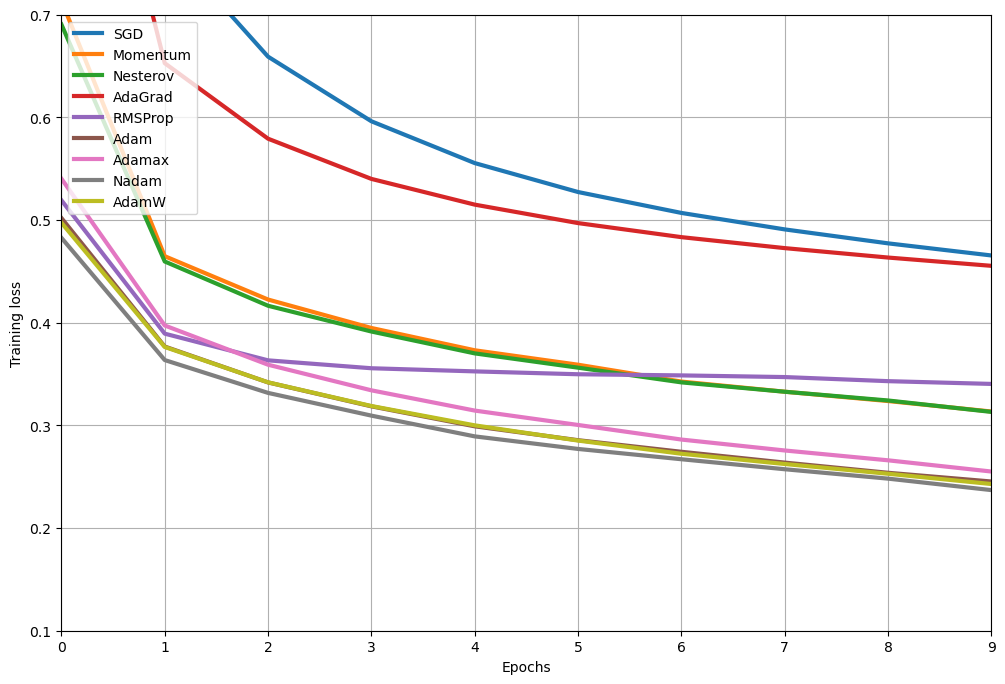

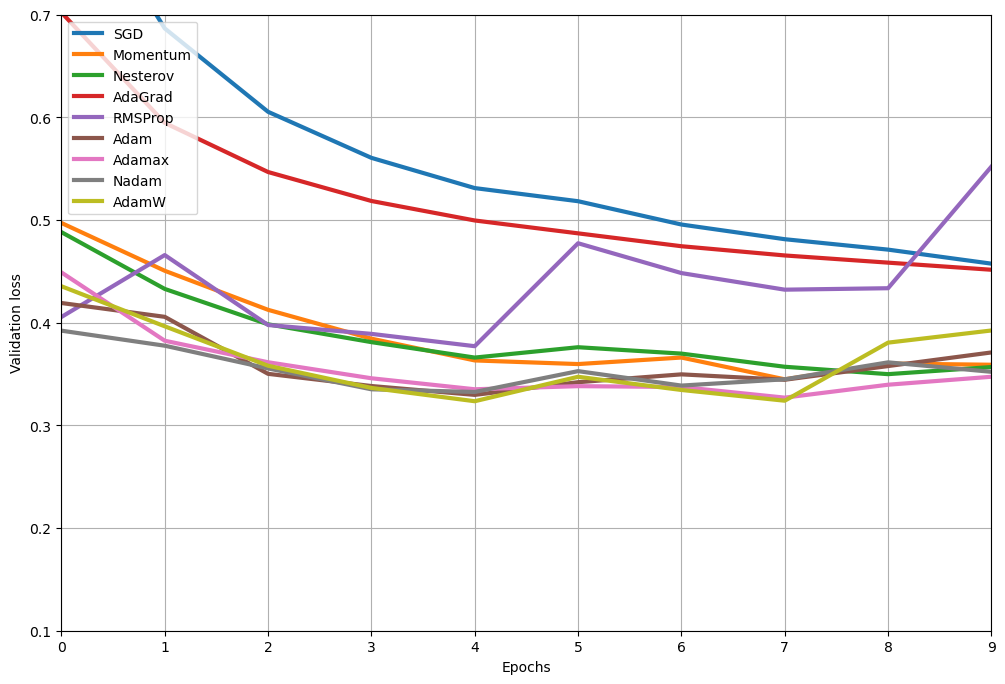

In [39]:
import matplotlib.pyplot as plt
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

自适应优化方法（包括RMSProp、Adam、AdaMax、Nadam和AdamW优化）通常非常好，可以快速收敛到一个好的解。

然而，有研究表明它们可以导致在某些数据集上泛化不佳的解。因此，当你对模型的性能感到失望时，请尝试改用动量优化/NAG：数据集可能对自适应梯度“过敏”。

表：优化器比较

| 优化器类别                              | 收敛速度 | 收敛质量      |
| :-------------------------------------- | :------- |:----------|
| SGD                                     | *        | ***       |
| SGD(momentum=...)                       | **       | ***       |
| SGD(momentum=..., nesterov=True)        | **       | ***       |
| Adagrad                                 | **       | *（停止太早）   |
| RMSprop                                 | **       | ** 或者 *** |
| Adam                                    | **       | ** 或者 *** |
| AdaMax                                  | **       | ** 或者 *** |
| Nadam                                   | **       | ** 或者 *** |
| AdamW                                   | **       | ** 或者 *** |

### 训练稀疏模型

刚刚讨论的所有优化算法都会产生密集模型，这意味着大多数参数都是非零的。如果在运行时需要一个非常快的模型，或者需要占用更少内存的模型，那么可能更喜欢使用一个稀疏模型。实现这一点的一个方法是像往常一样训练模型，然后去掉很小的权重（将它们设置为零）。但是，这通常不会导致非常稀疏的模型，而且可能会降低模型的性能。

一个更好的选择是在训练时使用强l1正则化，因为它会迫使优化器产生尽可能多的为零的权重。

如果这些技术仍然不够，请查看TensorFlow Model Optimization Toolkit (TF-MOT)，它提供了一个剪枝API，能够根据连接的大小在训练期间迭代地删除连接。

## 学习率调度

找到一个好的学习率非常重要。如果将学习率设置得太大，训练可能会发散；如果学习率设置得太小，训练会花费很长时间。如果学习率设置得稍大了点，它一开始会很快，但是最终会围绕最优解振荡，不会真正稳定下来

可以对模型进行数百次迭代训练，然后将学习率从很小的值成指数形式地增加到很大的值，再查看学习曲线并选择一个略低于学习曲线开始回升的学习率，然后，可以重新初始化模型，并以该学习率对其进行训练。

但是有比恒定学习率更好的做法：比如先采用一个较大的学习率，然后在训练不再取得进展后就降低它；比如先采用小的学习率再增加它，然后再降低，这些策略称为学习率调度，在介绍随机梯度下降的时候首次提到过它

### 幂调度 (Power Scheduling)

将学习率设置为迭代次数的函数：

$$\eta(t) = \frac{\eta_0}{(1 + t/s)^c}$$

其中初始学习率 $\eta_0$、幂 $c$（通常设置为 1）和步骤 $s$ 是超参数。学习率在每一步都会下降。在 $s$ 个步骤之后，学习率下降到 $\eta_0/2$。再在 $s$ 个步骤之后，它下降到 $\eta_0/3$，然后下降到 $\eta_0/4$，然后是 $\eta_0/5$，以此类推。

如你所见，此调度下学习率开始迅速下降，然后越来越慢。当然，幂调度需要调整 $\eta_0$ 和 $s$（可能还有 $c$）。

In [31]:
# learning_rate = initial_learning_rate / (1 + step / decay_steps)**power, step: 更新的次数，一个批次一次更新
# Keras 使用 power = 1

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False #  这个设置为True的话， floor(step / decay_step) 替代 step / decay_step
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [32]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6755 - accuracy: 0.7681 - val_loss: 0.4937 - val_accuracy: 0.8250
Epoch 2/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4792 - accuracy: 0.8302 - val_loss: 0.4613 - val_accuracy: 0.8310
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4341 - accuracy: 0.8467 - val_loss: 0.4222 - val_accuracy: 0.8464
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4105 - accuracy: 0.8557 - val_loss: 0.4062 - val_accuracy: 0.8582
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3921 - accuracy: 0.8616 - val_loss: 0.3910 - val_accuracy: 0.8590


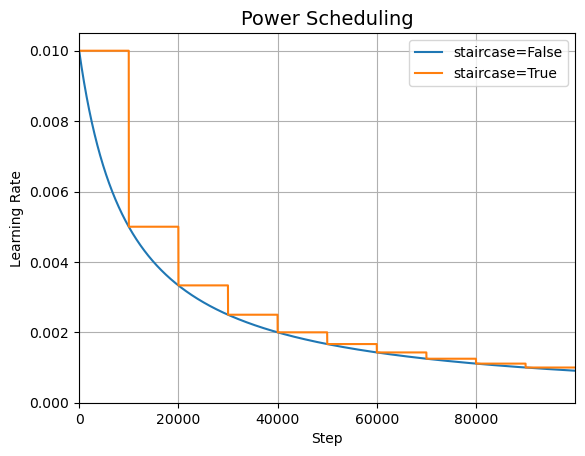

In [34]:
import numpy as np
import matplotlib.pyplot as plt

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 指数调度 (Exponential Scheduling)

将学习率设置为：

$$\eta(t) = \eta_0 \cdot 0.1^{t/s}$$

学习率以每 $s$ 步的速率逐渐变为原来的十分之一。幂调度降低学习率的速度越来越缓慢，而指数调度则使学习率每 $s$ 步变为原来的十分之一。

In [4]:
# learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [5]:
history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/5
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6984 - accuracy: 0.7614 - val_loss: 0.4899 - val_accuracy: 0.8296
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4783 - accuracy: 0.8312 - val_loss: 0.4607 - val_accuracy: 0.8312
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4323 - accuracy: 0.8472 - val_loss: 0.4163 - val_accuracy: 0.8508
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4086 - accuracy: 0.8551 - val_loss: 0.3965 - val_accuracy: 0.8586
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3912 - accuracy: 0.8631 - val_loss: 0.3875 - val_accuracy: 0.8608


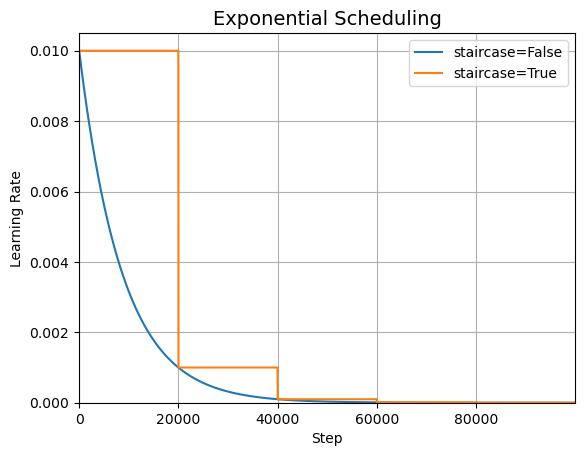

In [42]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# keras提供LearningRateScheduler的回调类，让你定义自己的调度函数

def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

# 如果想配置初始学习率 和 步数，可以创建一个返回配置函数的函数
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [44]:
# 接下来创建一个LearningRateScheduler回调函数，为其提供调度函数，然后将此回调函数传给fit方法
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6890 - accuracy: 0.7667 - val_loss: 0.4969 - val_accuracy: 0.8164 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4707 - accuracy: 0.8348 - val_loss: 0.4619 - val_accuracy: 0.8342 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4257 - accuracy: 0.8492 - val_loss: 0.4165 - val_accuracy: 0.8548 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4029 - accuracy: 0.8565 - val_loss: 0.3968 - val_accuracy: 0.8536 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3841 - accuracy: 0.8641 - val_loss: 0.3842 - val_accuracy: 0.8630 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3703 - accuracy: 0.8680 - val_loss: 0.3953 - val_accuracy: 0.8580 - lr: 0.0056
Epoch 7/20
1719/1719 [==============================] - 

LearningRateScheduler将在每个轮次开始时更新优化器的learning_rate属性，通常一个轮次更新一次学习率足够了，如果希望更频繁地更新学习率，则需要编写自己的回调函数类

In [53]:
class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        self.model.optimizer.learning_rate = new_learning_rate

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()

In [15]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [56]:
import math

batch_size = 32
n_epochs = 25

n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7173 - accuracy: 0.7555 - val_loss: 0.4936 - val_accuracy: 0.8332 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4738 - accuracy: 0.8341 - val_loss: 0.4555 - val_accuracy: 0.8372 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4245 - accuracy: 0.8493 - val_loss: 0.4105 - val_accuracy: 0.8580 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4006 - accuracy: 0.8593 - val_loss: 0.3885 - val_accuracy: 0.8640 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3817 - accuracy: 0.8647 - val_loss: 0.3908 - val_accuracy: 0.8602 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3670 - accuracy: 0.8699 - val_loss: 0.3867 - val_accuracy: 0.8650 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================] - 2s

### 分段恒定调度(Piecewise Constant Scheduling)

对一些轮次使用恒定的学习率（例如，对某5个轮次，使用η0=0.1），对另外一些轮次使用较小的学习率（例如，对某50个轮次，使用η0=0.001），以此类推。尽管这个方法可以很好地工作，但仍需要仔细研究以找出正确的学习率顺序以及使用它们的轮次。

In [6]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [7]:
history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6905 - accuracy: 0.7661 - val_loss: 0.4857 - val_accuracy: 0.8304
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4702 - accuracy: 0.8334 - val_loss: 0.4466 - val_accuracy: 0.8430
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4208 - accuracy: 0.8485 - val_loss: 0.4068 - val_accuracy: 0.8586
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3953 - accuracy: 0.8585 - val_loss: 0.3787 - val_accuracy: 0.8648
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3746 - accuracy: 0.8663 - val_loss: 0.3681 - val_accuracy: 0.8660


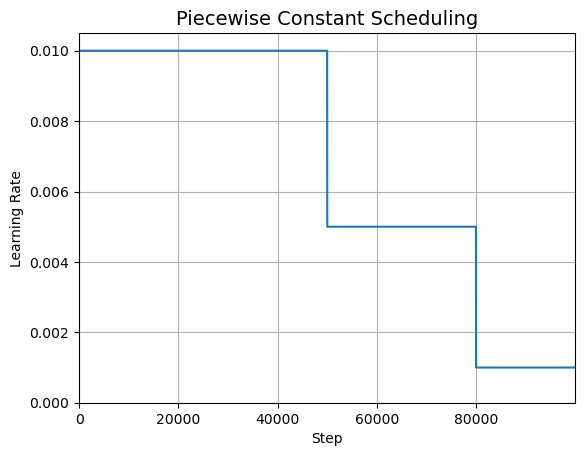

In [59]:
boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [8]:
# 像指数调度一样，可以手动实现分段恒定调度
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [13]:
# 可配置的实现
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)  # [0,5,15] > 0
    values = np.array(values)                # [0.01, 0.005, 0.001]
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [16]:
n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5479 - accuracy: 0.8056 - val_loss: 0.4736 - val_accuracy: 0.8194 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4624 - accuracy: 0.8376 - val_loss: 0.4824 - val_accuracy: 0.8220 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4389 - accuracy: 0.8452 - val_loss: 0.4599 - val_accuracy: 0.8396 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4314 - accuracy: 0.8489 - val_loss: 0.4117 - val_accuracy: 0.8552 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4156 - accuracy: 0.8543 - val_loss: 0.3959 - val_accuracy: 0.8606 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3595 - accuracy: 0.8704 - val_loss: 0.3883 - val_accuracy: 0.8600 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 4s

In [49]:
# 随堂练习：用回调的方式 实现分段恒定调度，0-50000批次 0.01, 50000-80000:0.005, 80000之后 0.001，看看和keras自带的效果是否一致；参考代码：
# class ExponentialDecay(tf.keras.callbacks.Callback):
#     def __init__(self, n_steps=40_000):
#         super().__init__()
#         self.n_steps = n_steps
#
#     def on_batch_begin(self, batch, logs=None):
#         lr = self.model.optimizer.learning_rate.numpy()
#         new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
#         self.model.optimizer.learning_rate = new_learning_rate
#
#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         logs['lr'] = self.model.optimizer.learning_rate.numpy()

class PiecewiseDecay(tf.keras.callbacks.Callback):
    def __init__(self, boundaries, values):
        super().__init__()
        self.boundaries = np.array([0] + boundaries)
        self.values = np.array(values)
        self.steps = 0

    def on_batch_begin(self, batch, logs):
        self.steps += 1
        lr = self.values[(self.boundaries > self.steps).argmax() - 1]
        self.model.optimizer.learning_rate = lr

    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=35,
                    validation_data=(X_valid, y_valid),
                    callbacks=[PiecewiseDecay([50000, 80000], [0.01, 0.005, 0.001])])

Epoch 1/35
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5499 - accuracy: 0.8046 - val_loss: 0.5106 - val_accuracy: 0.8048 - lr: 0.0100
Epoch 2/35
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4624 - accuracy: 0.8387 - val_loss: 0.4715 - val_accuracy: 0.8300 - lr: 0.0100
Epoch 3/35
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4333 - accuracy: 0.8470 - val_loss: 0.4366 - val_accuracy: 0.8460 - lr: 0.0100
Epoch 4/35
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4234 - accuracy: 0.8520 - val_loss: 0.4730 - val_accuracy: 0.8370 - lr: 0.0100
Epoch 5/35
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4128 - accuracy: 0.8558 - val_loss: 0.4691 - val_accuracy: 0.8404 - lr: 0.0100
Epoch 6/35
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4157 - accuracy: 0.8549 - val_loss: 0.4426 - val_accuracy: 0.8572 - lr: 0.0100
Epoch 7/35
1719/1719 [==============================] - 4s

In [26]:
# 已经见过InverseTimeDecay（幂调度）, ExponentialDecay（指数调度）, and PiecewiseConstantDecay（分段恒定调度）， 可以看下tf.keras.optimizers.schedules的完整列表
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)  # python的反射： 通过字符串 获取属性/方法
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


In [25]:
dir(tf.keras.optimizers.schedules)
dir("a")

content = """
1111
222
3333
"""
content.splitlines()


1111
222
3333



['', '1111', '222', '3333']

### 性能调度（Performance Scheduling）

每N步测量一次验证误差（就像早停一样），并且当误差停止下降时，将学习率降为原来的λ分之一。

In [27]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [28]:
# 性能调度 使用ReduceLROnPlateau回调函数
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)  # 连续5个轮次的最好验证损失都没有改善时，将使学习率*0.5
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7062 - accuracy: 0.7608 - val_loss: 0.4956 - val_accuracy: 0.8292 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4772 - accuracy: 0.8329 - val_loss: 0.4580 - val_accuracy: 0.8346 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4291 - accuracy: 0.8470 - val_loss: 0.4194 - val_accuracy: 0.8488 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4035 - accuracy: 0.8570 - val_loss: 0.3949 - val_accuracy: 0.8614 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3822 - accuracy: 0.8637 - val_loss: 0.3774 - val_accuracy: 0.8608 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3653 - accuracy: 0.8679 - val_loss: 0.3875 - val_accuracy: 0.8622 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 3s

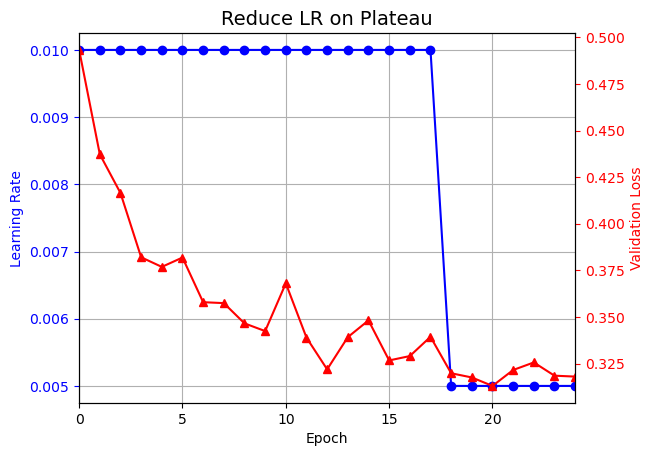

In [68]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1周期调度（One Cycle Scheduling）

它首先增加初始学习率eta0，使其在训练中途线性增长至eta1。然后，它在训练啊的后半部分将学习率再次线性降低到eta0，通过将学习率降低几个数量级来完成最后几个轮次。使用与找到最优学习率相同的方法来选择最大学习率eta1（损失开始发散的学习率），而初始学习率eta0通常是原来的十分之一。

ExponentialLearningRate 自定义回调会在训练期间，即每个批次结束时更新学习率。它会将学习率乘以一个常数因子。它还会保存每个批次的学习率和损失。由于 logs["loss"] 实际上是自该周期开始以来的平均损失，而想要保存的是批次损失，因此必须计算平均值乘以自该周期开始以来的批次数，以获得迄今为止的总损失，然后减去上一个批次的总损失，以获得当前批次的损失。

In [29]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # 这个轮次迄今为止的平均损失
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

In [30]:
# find_learning_rate() 函数使用 ExponentialLearningRate 回调函数训练模型，并返回学习率和相应的批次损失。最后，它将模型及其优化器恢复到初始状态。
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [31]:
# plot_lr_vs_loss() 函数绘制了学习率与损失的关系图。最佳学习率（可用作 1 个周期内的最大学习率）位于曲线底部附近。
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [32]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

430/430 [==============================] - 1s 2ms/step - loss: 1.7769 - accuracy: 0.3800


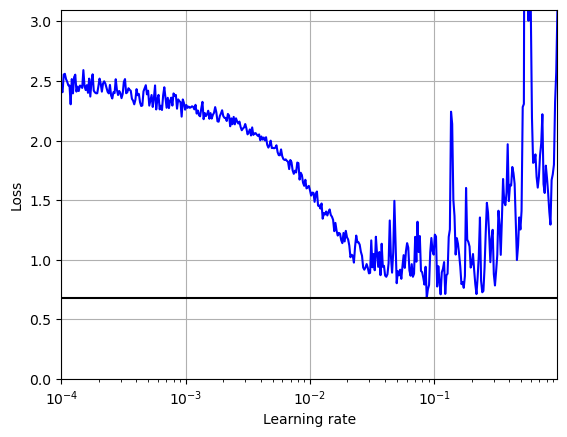

In [35]:
# 找一周期调度的最佳学习率
import math
import matplotlib.pyplot as plt

batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [37]:
# OneCycleScheduler 自定义回调会在每个批次开始时更新学习率。
# 在训练的大约一半时间内线性增加学习率，然后线性降低回初始学习率。
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

In [38]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 3ms/step - loss: 0.9689 - accuracy: 0.6817 - val_loss: 0.6078 - val_accuracy: 0.8028
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.5802 - accuracy: 0.8005 - val_loss: 0.4918 - val_accuracy: 0.8278
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.5012 - accuracy: 0.8229 - val_loss: 0.4607 - val_accuracy: 0.8314
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4562 - accuracy: 0.8388 - val_loss: 0.4515 - val_accuracy: 0.8362
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4290 - accuracy: 0.8463 - val_loss: 0.4117 - val_accuracy: 0.8488
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4018 - accuracy: 0.8554 - val_loss: 0.4757 - val_accuracy: 0.8304
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3857 - accuracy: 0.8601 - val_loss: 0.4025 - val_accuracy: 0.8524
Epoch 

## 通过正则化避免过拟合

深度神经网络通常具有数万个参数，有时有数百万个。这使它们非常灵活，意味着它们可以拟合各种各样的复杂数据集。但是，这种巨大的灵活性也使网络易于过拟合训练集。通常需要采用正则化防止这种情况。

之前已经实现了一项正则化技术：早停。而且“批量归一化”被设计用来解决不稳定梯度问题，但它也能起到很好的正则化作用。

其他流行的神经网络正则化技术：l1和l2正则化，以及dropout和最大范数正则化

### l1和l2正则化

In [39]:
# 可以使用l2正则化约束神经网络的连接权重，如果想要稀疏模型（许多权重为0），则可以使用l1正则化
import tensorflow as tf
layer = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L2(0.01)) # 用0.01的正则化因为将l2正则化应用于Keras层的连接权重

l2()返回一个正则化函数，在训练过程中的每个步骤都将调用该正则化函数来计算正则化损失，添加到最终损失

或者使用 l1(0.1) 进行 ℓ1 正则化，其因子为 0.1，或者使用 l1_l2(0.1, 0.01) 进行 ℓ1 和 ℓ2 正则化，其因子分别为 0.1 和 0.01。

由于通常希望将相同的正则化函数应用于网络中的所有层，并在所有隐藏层中使用相同的激活函数和相同的初始化策略，因此你可能会发现自己在重复使用相同的参数。这使代码很难看且容易出错。为了避免这种情况，可以尝试使用循环来重构代码。另一种选择是使用Python的functools.partial()函数，该函数允许你为带有任何默认参数值的任何可调用对象创建一个小的包装函数：

In [43]:
from functools import partial

def mul(x, y):
    return x*y

double = partial(mul, 2)
double(3)
double(9)

callable(tf.keras.layers.Dense)  # True

True

In [44]:
from functools import partial
RegularizedDense = partial(tf.keras.layers.Dense, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L2(0.01))

model =tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
    ])

l2正则化在使用SGD、动量优化和Nesterov动量优化时很好，但不适用于Adam及其变体。如果想使用具有权重衰减的Adam，则不要使用l2正则化：改用AdamW。

In [ ]:
# 动量优化 / Nesterov的动量优化
# l1_l2
# partial去搭建每个层



### dropout

已被证明是非常成功的：许多先进的神经网络都使用了dropout

这是一个非常简单的算法：在每个训练步骤中，每个神经元（包括输入神经元，但始终不包括输出神经元）都有暂时被“删除”(dropped out)的概率p，这意味着在这个训练步骤中它被完全忽略，但在下一步中可能处于活动状态。超参数p称为dropout率，通常设置为10%～50%：在循环神经网络中在20%～30%，在卷积神经网络中在40%～50%。训练后，神经元不再被“删除”。这就是全部内容（除了一个技术细节）

![一层或多层中的所有神经元随机被删除，输出层除外](./images/neural_network/p14.png)

类比：不能依靠任何一个人来执行任何关键任务，必须将这种专业知识分散到多个人身上。员工必须学会与许多同事（而不仅仅是少数几个）合作。该公司将变得更具弹性。如果一个人辞职，不会有太大的影响。尚不清楚这种想法是否真的适用于公司，但它确实适用于神经网络。

经过dropout训练的神经元不能与其相邻的神经元相互适应。它们必须自己发挥最大的作用，它们也不能过分依赖少数输入神经元，它们必须注意每个输入神经元。它们最终对输入的微小变化不太敏感。最后，将获得一个更有鲁棒性的网络，该网络有更好的泛化能力。

了解dropout能力的另一种方法是认识到在每个训练步骤中都会生成一个独特的神经网络。由于每个神经元都可以存在或不存在，因此共有2^N个可能的网络（其中N是可以被“删除”的神经元的总数）。

这是一个巨大的数字，几乎不可能对同一神经网络进行两次采样。一旦运行了10000个训练步骤，实质上就已经训练了10000个不同的神经网络，每个神经网络只有一个训练实例。这些神经网络显然不是独立的，因为它们共享许多权重，但是它们是完全不同的。所得的神经网络可以看作所有这些较小的神经网络的平均集成。

有一个小而重要的技术细节。假设p=75%：在训练期间的每一步平均只有25%的神经元处于活动状态, 或者说一个神经元训练期间的输出的期望值只有正常的25%；这意味着在训练之后，不使用dropout一个神经元将连接到4倍于训练期间的输入神经元。

为了弥补这一事实，需要训练期间将Dropout层的连接权重乘以4，如果不这样做，会导致网络在预测时输出尺度发生变化，推理和训练不一致，表现不会好。更一般地说，需要在训练期间将连接权重除以保留概率（1-p）

要使用Keras实现dropout，可以使用tf.keras.layers.Dropout层。在训练期间，它会随机丢弃一些输入（将它们设置为0），然后将其余输入除以保留概率。训练之后，它什么都不做；只将输入传递到下一层。以下代码使用0.2的dropout率在每个密集层之前应用dropout正则化：

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [60]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6781 - accuracy: 0.7501 - val_loss: 0.4598 - val_accuracy: 0.8310
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5103 - accuracy: 0.8143 - val_loss: 0.4244 - val_accuracy: 0.8302
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4772 - accuracy: 0.8245 - val_loss: 0.3996 - val_accuracy: 0.8482
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4498 - accuracy: 0.8342 - val_loss: 0.3724 - val_accuracy: 0.8624
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4392 - accuracy: 0.8382 - val_loss: 0.3730 - val_accuracy: 0.8602
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4262 - accuracy: 0.8423 - val_loss: 0.3682 - val_accuracy: 0.8628
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4170 - accuracy: 0.8467 - val_loss: 0.3721 - val_accuracy:

训练集的准确率看起来似乎低于验证集的准确率，但这仅仅是因为dropout只在训练过程中起作用，验证集上评估会关掉dropout。

如果在训练结束后（即关闭dropout）在训练集上评估模型，会得到“真实”的训练集准确率，它比验证集准确率和测试集准确率略高：

In [47]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.3175 - accuracy: 0.8827


[0.31749552488327026, 0.8827454447746277]

In [48]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3735 - accuracy: 0.8668


[0.37351471185684204, 0.8668000102043152]

由于dropout仅在训练期间激活，因此比较训练损失和验证损失可能会产生误导。具体而言，模型可能会过度拟合训练集，但仍具有相似的训练损失和验证损失。因此，确保在没有使用dropout的情况下评估训练损失（比如，在训练之后）

dropout确实会显著减慢收敛速度，但如果调整得当，它通常会产生更好的模型。因此，通常值得为它花费一些额外的时间和精力，尤其是对于大型模型。

如果要基于SELU激活函数对自归一化网络进行正则化，则应使用alpha dropout：这是dropout的一种变体，它保留了输入的均值和标准差。它在与SELU相同的论文中介绍，因为常规的dropout会破坏自归一化。

### 蒙特卡罗（MC）dropout

这个技术可以提高任何训练后的dropout模型的性能，而无须重新训练。

它可以更好地衡量模型的不确定性，只需几行代码即可实现

In [61]:
import numpy as np

y_probas = np.stack([model(X_test, training=True) for sample in range(100)])  # 开了dropout去对测试集做100次预测
y_probas


array([[[1.7430858e-06, 1.6083271e-06, 2.0838016e-07, ...,
         1.3600974e-01, 1.3624360e-06, 8.2418162e-01],
        [4.5310584e-04, 1.0011246e-06, 9.9288601e-01, ...,
         1.4953674e-08, 5.8057722e-06, 1.0602630e-08],
        [4.3468212e-04, 9.9563521e-01, 4.1435289e-08, ...,
         4.7205244e-06, 1.8175125e-07, 3.7646265e-07],
        ...,
        [1.1126010e-04, 4.6700914e-09, 4.0301155e-05, ...,
         1.5743787e-08, 9.9982810e-01, 6.6549370e-11],
        [8.3706655e-05, 9.9729055e-01, 1.8570051e-06, ...,
         3.1922973e-04, 8.1594269e-05, 3.4403778e-04],
        [3.2064993e-06, 8.2976112e-07, 1.1170296e-05, ...,
         2.3066318e-02, 1.1637400e-05, 3.3192095e-04]],

       [[1.8378376e-05, 1.1314914e-05, 8.1775244e-07, ...,
         1.9545750e-01, 1.1987036e-05, 7.9864019e-01],
        [2.8632411e-07, 3.7242356e-10, 9.9977273e-01, ...,
         6.4693290e-12, 2.8489002e-09, 3.6686054e-12],
        [1.0328087e-11, 1.0000000e+00, 2.5132012e-17, ...,
         1.452

In [62]:
y_probas.shape
y_proba = y_probas.mean(axis=0)
y_proba

array([[1.18526375e-04, 1.35677983e-04, 6.60137157e-05, ...,
        2.49569058e-01, 2.92631099e-04, 6.51555002e-01],
       [1.23263011e-03, 1.63695760e-04, 9.57782447e-01, ...,
        2.95638274e-05, 6.07205380e-04, 1.26657496e-05],
       [5.38719223e-06, 9.99944508e-01, 3.30730310e-09, ...,
        2.81075722e-06, 4.06182004e-08, 1.82274974e-07],
       ...,
       [1.86692588e-02, 2.16621065e-05, 3.63571406e-03, ...,
        4.66266538e-05, 9.56595659e-01, 2.24053701e-06],
       [5.37698179e-06, 9.99270201e-01, 1.83868406e-06, ...,
        1.09387758e-04, 6.56345628e-06, 1.77819631e-04],
       [1.10486452e-03, 4.30318294e-04, 2.92198127e-03, ...,
        1.78790286e-01, 6.97932858e-03, 3.81342741e-03]], dtype=float32)

model(X)类似于model.predict(X)，只是它返回张量而不是NumPy数组，并且它支持training参数。设置training=True可确保Dropout层保持活动状态，因此所有预测都会有所不同。

只对测试集进行100次预测，然后计算它们的平均值。更具体地说，每次调用模型都会返回一个矩阵，每个实例一行，每个类别一列。因为测试集有10000个实例和10个类别中，所以这是一个形状为[10000，10]的矩阵。

堆叠100个这样的矩阵，所以y_probas是一个形状为[100，10000，10]的三维数组。一旦对第一个维度(axis=0)进行平均，就会得到y_proba，一个形状为[10000，10]的数组，就像通过单次预测得到的一样。

在启用dropout的情况下对多次预测的结果进行平均可以得到蒙特卡罗估计值，该估计值通常比关闭dropout的单次预测的结果更可靠。例如，看看模型对Fashion MNIST测试集中第一个实例的预测（关闭dropout）：

In [63]:
print(model.predict(X_test[:1]).round(3))
print(y_proba[0].round(3))  # MC Dropout会把置信度往下调

1/1 [==============================] - 0s 50ms/step
[[0.    0.    0.    0.    0.    0.03  0.    0.183 0.    0.787]]
[0.    0.    0.    0.    0.    0.098 0.    0.25  0.    0.652]


MC dropout倾向于提高模型概率估计的可靠性。-> 它意味着更不可能非常自信却做错事情，准确了解哪些其他类别最优可能也很有用（自动驾驶汽车了解识别到的可能的各种标志）

In [65]:
# 查看概率估计的标准差
y_std = y_probas.std(axis=0)
y_std[0].round(3)
# y_std[0].round(3)

# 第9类的概率估计值存在很大差异：标准差0.175. 应该把估计的概率和标准差结合在一起 （代表概率有很大不确定性），如果构建一个风险敏感的任务，会谨慎对待这样不确定的预测

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.135, 0.   , 0.186, 0.001,
       0.215], dtype=float32)

In [66]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8664

使用的蒙特卡罗样本数量（在此样例中为100）是可以调整的超参数。数值越高，预测及其不确定性估计的精度就越高。但是，如果将其加倍，则推理时间也将加倍。此外，多于一定数量的样本，你几乎看不到任何改善。因此，你的工作就是在延迟和精度之间找到适当的平衡，具体取决于应用。

如果模型包含在训练过程中以特殊方式运行的其他层（例如BatchNormalization层），则不应像刚才那样强制采用训练模式(model(..., training=True))。相反，应该使用以下MCDropout类来替换Dropout层

解释：
训练模式：BN 层用当前 mini-batch 的均值/方差，并且还会更新 moving mean/var。 推理模式：BN 层用累计的 moving mean/var（稳定的全局统计量），不再更新。 使用model(..., training=True)意味着BN层的推理也按训练模式进行，不符合BN层的工作性质

In [15]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)


在这里，只是继承了Dropout层，并覆盖call()方法来将training参数强制设置为True。

同样，可以通过继承AlphaDropout来定义MCAlphaDropout类。如果要从头开始创建模型，则只需使用MCDropout而不是Dropout。

但是，如果有一个已经使用Dropout训练过的模型，那么需要创建一个与现有模型相同的新模型（只不过不使用Dropout而是使用MCDropout），然后将现有模型的权重复制到新模型。简而言之，MC dropout是一种很棒的技术，可以提升dropout模型性能并提供更好的不确定性估计。当然，由于这只是训练期间的常规dropout，因此它也像正则化函数。

### 最大范数正则化

另一种流行的神经网络正则化技术称为**最大范数 (max-norm) 正则化**：
对于每个神经元，它会限制传入连接的权重 **w**，使得 $\|w\|_2 \leq r$，其中 *r* 是最大范数超参数，$\|\cdot\|_2$ 是 $\ell_2$ 范数。

最大范数正则化不会把正则化损失项加到总体损失函数中。取而代之的是，通常在每个训练步骤后通过计算 $\|w\|_2$ 来实现，如有需要，请重新缩放：

$$
w \leftarrow w \cdot \frac{r}{\max(r, \|w\|_2)}
$$

最大范数正则化会增加正则化的强度，并有助于降低过拟合风险。
最大范数正则化还可以帮助缓解不稳定的梯度问题（如果未使用“批量归一化”）。


In [16]:
dense = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_constraint=tf.keras.constraints.max_norm(1.))

In [18]:
# 随堂练习： 填充如下代码，最终训练 用了最大范数正则化技术的 神经网络

MaxNormDense = ... # todo：使用partial 冻结Dense的除了神经元数量的其他参数， 指定使用最大范数正则化

model = ... # todo：使用Sequential搭建 2个隐藏层，每个都100神经元的网络 （使用上MaxNormDense）
optimizer = ... # todo: 创建使用动量优化的优化器

... # todo: 编译模型
history = ... # todo: 训练模型

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5419 - accuracy: 0.8083 - val_loss: 0.4679 - val_accuracy: 0.8204
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4090 - accuracy: 0.8496 - val_loss: 0.3926 - val_accuracy: 0.8564
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3767 - accuracy: 0.8613 - val_loss: 0.4141 - val_accuracy: 0.8486
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3587 - accuracy: 0.8685 - val_loss: 0.3436 - val_accuracy: 0.8728
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3436 - accuracy: 0.8724 - val_loss: 0.3517 - val_accuracy: 0.8706
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3391 - accuracy: 0.8731 - val_loss: 0.3656 - val_accuracy: 0.8610
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3303 - accuracy: 0.8767 - val_loss: 0.3367 - val_accuracy:

每次训练迭代后，模型的fit()方法会调用由max_norm()返回的对象，将层的权重传递给该对象，并获得返回的缩放权重，然后替换该层的权重。

如果需要，可以定义自己的自定义约束函数，并将其用作kernel_constraint。还可以通过设置bias_constraint参数来约束偏置项。

max_norm()函数的axis参数默认为0。密集层(Dense)通常具有形状为［输入数量，神经元数量］的权重，因此axis=0意味着最大范数约束将独立应用于每个神经元的权重向量。

如果要将最大范数约束用于卷积层，请确保正确设置max_norm()约束的axis参数（通常axis=[0，1，2]）。

## 总结各种技术

想知道该用哪种技术，取决于任务，没有明确共识，总结大多数情况下可以很好工作的配置，但不要把它当成规定

超参数 | 默认值
---|---
核初始化 | He 初始化
激活函数 | 对于浅层网络，采用 ELU；对于深度网络，采用 Swish
归一化 | 对于浅层网络，不需要；对于深度网络，采用批量归一化
正则化 | 早停，如有需要，可采用权重衰减
优化器 | Nesterov 加速梯度或 AdamW
学习率调度 | 性能调度或者 1 周期调度



超参数 | 默认值
---|---
核初始化 | LeCun 初始化
激活函数 | SELU
归一化 | 不需要
正则化 | 如果需要，则采用 Alpha dropout
优化器 | Nesterov 加速梯度
学习率调度 | 性能调度或者 1 周期调度

使用SELU不要忘了归一化输入特征！

如果可以找到解决类似问题的神经网络，就应该尝试重用部分神经网络；如果有大量未标记的数据，则应进行无监督预训练；如果有相似任务的大量标记的数据，则应该在辅助任务上进行训练。

虽然表格应该能涵盖大多数情况，但以下是一些例外的情况：

- 如果需要稀疏模型，则可以使用 l1 正则化（可以选择在训练后将很多小的权重归零）。如果需要更稀疏的模型，则可以使用 TensorFlow 模型优化工具包。l1正则化会破坏自归一化，因此在这种情况下，应使用默认配置。

- 如果需要低延迟模型（能够快速执行预测的模型），则可能需要使用更少的层，使用快速激活函数，例如 ReLU 或 leaky ReLU，并在训练后将批量归一化层折叠到前面的层中。拥有稀疏的模型也有帮助。最后，可能想把模型浮点精度从 32 位降低到 16 位甚至 8 位。再一次检查 TF-MOT。

- 如果要构建风险感知的应用，或者推理延迟不是很重要的情况下，则可以使用 MC Dropout 来提高性能并获得更可靠的概率估计以及不确定性估计。

有了这些准则，可以训练非常深的网络了！

除了目前用过的方便的Keras API，有时候可能需要进行更多的控制，例如，编写自定义损失函数或调整训练算法。对于这种情况，则需要使用TensorFlow的较低级API


In [37]:
# 随堂练习：实验目标：Dropout vs AlphaDropout 对比（针对 SELU 激活函数）

def build_model(use_alphaDropout=False):
  ...
